# **website features Ensemble modeling **

In [ ]:
!apt update > /dev/null
!apt install chromium-chromedriver > /dev/null
!cp /usr/lib/chromium-browser/chromedriver /usr/bin
!pip install selenium tldextract tranco whois > /dev/null

import sys
sys.path.insert(0, '/usr/lib/chromium-browser/chromedriver')



W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


cp: '/usr/lib/chromium-browser/chromedriver' and '/usr/bin/chromedriver' are the same file


In [ ]:
import time
import requests
import tldextract
import numpy as np
import joblib
import whois
from datetime import datetime
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from urllib.parse import urlparse, urljoin
from tranco import Tranco

# --- Keys ---
PAGE_RANK_API_KEY = "kokc4000kssowwk88co0cs0cgggwg0so408koo4k"
SERPAPI_KEY = "b5c6a916829ee5ff72a5ee88b2d57d33521dc6d5d4a24cf0b06addc8dd6a5c8f"

# --- Chrome driver setup ---
def get_driver():
    chrome_options = Options()
    chrome_options.add_argument("--headless")
    chrome_options.add_argument("--no-sandbox")
    chrome_options.add_argument("--disable-dev-shm-usage")
    driver = webdriver.Chrome(options=chrome_options)
    return driver

# --- PageRank ---
def page_rank(domain):
    try:
        url = f'https://openpagerank.com/api/v1.0/getPageRank?domains[]={domain}'
        headers = {'API-OPR': PAGE_RANK_API_KEY}
        response = requests.get(url, headers=headers)
        data = response.json()
        rank = data['response'][0].get('page_rank_integer')
        return rank if rank is not None else 0
    except:
        return -1

# --- Google Index ---
def google_index_serpapi(url):
    try:
        params = {
            "engine": "google",
            "q": f"site:{url}",
            "api_key": SERPAPI_KEY
        }
        response = requests.get("https://serpapi.com/search", params=params)
        data = response.json()
        for result in data.get("organic_results", []):
            if result.get("link", "").startswith(url):
                return 1
        return 0
    except:
        return -1

# --- Tranco Rank ---
def get_tranco_rank(domain):
    try:
        ext = tldextract.extract(domain)
        registered_domain = f"{ext.domain}.{ext.suffix}"
        t = Tranco()
        tranco_list = t.list()
        domain_rankings = tranco_list.top(1000000)
        if registered_domain in domain_rankings:
            rank = domain_rankings.index(registered_domain) + 1
            return rank
        else:
            return 0
    except:
        return 0

# --- Selenium Feature Extractor ---
def extract_features_selenium(url):
    driver = get_driver()
    try:
        driver.get(url)
        time.sleep(3)

        html = driver.page_source
        parsed = urlparse(driver.current_url)
        domain = parsed.netloc
        path = parsed.path.lower()

        # 1. login_form
        login_form = int(len(driver.find_elements('xpath', '//input[@type="password"]')) > 0)

        # 2. links_in_tags
        suspicious_tags = ['script', 'meta', 'link', 'style']
        suspicious_count = sum(len(driver.find_elements('tag name', tag)) for tag in suspicious_tags)
        a_tags = driver.find_elements('tag name', 'a')
        total_links = len(a_tags)
        links_in_tags = suspicious_count / total_links if total_links else 0

        # 3. iframe
        iframe = int(len(driver.find_elements('tag name', 'iframe')) > 0)

        # 4. right_click
        right_click = int("contextmenu" in html or "event.button==2" in html)

        # 5. empty_title
        try:
            title = driver.title.strip()
            empty_title = int(title == "")
        except:
            empty_title = 1

        # 6. safe_anchor
        safe_anchor = sum(1 for a in a_tags if a.get_attribute('href') in ['#', 'javascript:void(0)', 'javascript:;'])
        safe_anchor = safe_anchor / total_links if total_links else 0

        # 7 & 8. Internal/External links
        int_links, ext_links = 0, 0
        for a in a_tags:
            href = a.get_attribute('href')
            if not href: continue
            full_url = urljoin(url, href)
            link_domain = urlparse(full_url).netloc
            if domain in link_domain or link_domain == '':
                int_links += 1
            else:
                ext_links += 1
        total = int_links + ext_links
        ratio_intHyperlinks = int_links / total if total else 0
        ratio_extHyperlinks = ext_links / total if total else 0

        # 9. nb_extCSS
        css_links = driver.find_elements('xpath', '//link[@rel="stylesheet"]')
        nb_extCSS = sum(1 for l in css_links if l.get_attribute('href') and l.get_attribute('href').startswith('http'))

        # 10. nb_redirection
        nb_redirection = 0  # You could use Selenium Navigation logs (not in headless Chrome easily)

        # 11 & 12. WHOIS
        try:
            w = whois.whois(domain)
            creation = w.creation_date[0] if isinstance(w.creation_date, list) else w.creation_date
            expiration = w.expiration_date[0] if isinstance(w.expiration_date, list) else w.expiration_date
            now = datetime.now()
            domain_registration_length = (expiration - creation).days if creation and expiration else -1
            domain_age = (now - creation).days if creation else -1
        except:
            domain_registration_length = -1
            domain_age = -1

        # 13. web_traffic
        web_traffic = get_tranco_rank(domain)

        # 14. google_index
        google_index = google_index_serpapi(driver.current_url)

        # 15. page_rank
        page_rank_val = page_rank(domain)

        # 16. brand_in_path
        brands = ['paypal', 'google', 'amazon', 'facebook', 'bank', 'microsoft', 'netflix', 'apple']
        brand_in_path = int(any(b in path for b in brands))

        # 17. suspecious_tld
        tld = '.' + domain.split('.')[-1]
        suspecious_tld = int(tld in ['.tk', '.ml', '.ga', '.cf', '.gq'])

        return {
            'login_form': login_form,
            'links_in_tags': links_in_tags,
            'iframe': iframe,
            'right_click': right_click,
            'empty_title': empty_title,
            'safe_anchor': safe_anchor,
            'ratio_intHyperlinks': ratio_intHyperlinks,
            'ratio_extHyperlinks': ratio_extHyperlinks,
            'nb_extCSS': nb_extCSS,
            'nb_redirection': nb_redirection,
            'domain_registration_length': domain_registration_length,
            'domain_age': domain_age,
            'web_traffic': web_traffic,
            'google_index': google_index,
            'page_rank': page_rank_val,
            'brand_in_path': brand_in_path,
            'suspecious_tld': suspecious_tld
        }
    except Exception as e:
        print(f"Error extracting from {url}: {e}")
        return None
    finally:
        driver.quit()


In [ ]:
# Load models
model1 = joblib.load("/content/drive/MyDrive/rough/xgb_dataset3.pkl")
model2 = joblib.load("/content/drive/MyDrive/rough/rf_dataset3.pkl")
mlp_model = joblib.load("/content/drive/MyDrive/rough/mlp_dataset3.pkl")
model4 = joblib.load("/content/drive/MyDrive/rough/lightgbm_model.pkl")
scaler = joblib.load("/content/drive/MyDrive/rough/scaler_dataset3.pkl")

# Feature order used in all models (assumed same for MLP)
feature_columns = [
    'login_form', 'links_in_tags', 'iframe', 'right_click', 'empty_title',
    'safe_anchor', 'ratio_intHyperlinks', 'ratio_extHyperlinks', 'nb_extCSS',
    'nb_redirection', 'domain_registration_length', 'domain_age', 'web_traffic',
    'google_index', 'page_rank', 'brand_in_path', 'suspecious_tld'
]

def predict_with_models(url):
    features = extract_features_selenium(url)
    if not features:
        print("Feature extraction failed.")
        return

    x_input = np.array([features[col] for col in feature_columns]).reshape(1, -1)

    # Apply scaler for MLP model only
    x_scaled = scaler.transform(x_input)

    # Get predictions
    pred1 = model1.predict(x_input)[0]
    pred2 = model2.predict(x_input)[0]
    pred3 = mlp_model.predict(x_scaled)[0]
    pred4 = model4.predict(x_input)[0]

    # Convert to labels
    label1 = "Phishing" if pred1 == 0 else "Legitimate"
    label2 = "Phishing" if pred2 == 0 else "Legitimate"
    label3 = "Phishing" if pred3 == 0 else "Legitimate"
    label4 = "Phishing" if pred4 == 0 else "Legitimate"

    print(f"[XGBoost] Prediction: {label1}")
    print(f"[Random Forest] Prediction: {label2}")
    print(f"[MLP] Prediction: {label3}")
    print(f"[LightBGM] Prediction: {label4}")

# Example usage
predict_with_models("https://bnl.it/it")


[XGBoost] Prediction: Legitimate
[Random Forest] Prediction: Legitimate
[MLP] Prediction: Phishing
[LightBGM] Prediction: Legitimate


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
predict_with_models("https://www.youtube.com/live/o80gt3hAFlU")

[XGBoost] Prediction: Legitimate
[Random Forest] Prediction: Legitimate
[MLP] Prediction: Legitimate
[LightBGM] Prediction: Legitimate


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
predict_with_models("https://school.careers360.com/schools/st-marys-matriculation-boys-higher-secondary-school-perambur")

[XGBoost] Prediction: Legitimate
[Random Forest] Prediction: Legitimate
[MLP] Prediction: Legitimate
[LightBGM] Prediction: Legitimate


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
predict_with_models("https://www.meesho.com/?srsltid=AfmBOopFc0Np7uFu8tsixUznjNFaer-3xvG3uK585QdaDCVrysoJtaQ_")

[XGBoost] Prediction: Legitimate
[Random Forest] Prediction: Legitimate
[MLP] Prediction: Legitimate
[LightBGM] Prediction: Legitimate


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
predict_with_models("https://sbatestsite.com")

[XGBoost] Prediction: Legitimate
[Random Forest] Prediction: Legitimate
[MLP] Prediction: Legitimate
[LightBGM] Prediction: Legitimate


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
predict_with_models("https://smiley-chocolate-oyster.slab.com/login?redirect=%2Fposts%2Fofficial-payment-receip...")

[XGBoost] Prediction: Phishing
[Random Forest] Prediction: Phishing
[MLP] Prediction: Phishing
[LightBGM] Prediction: Phishing


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
predict_with_models("https://growthsuplementtos.com.br/")

[XGBoost] Prediction: Phishing
[Random Forest] Prediction: Phishing
[MLP] Prediction: Legitimate
[LightBGM] Prediction: Phishing


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
predict_with_models("	http://fhqomigxjt.com")

[XGBoost] Prediction: Phishing
[Random Forest] Prediction: Phishing
[MLP] Prediction: Phishing
[LightBGM] Prediction: Phishing


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
predict_with_models("https://www.amazon.in/")

[XGBoost] Prediction: Legitimate
[Random Forest] Prediction: Legitimate
[MLP] Prediction: Legitimate
[LightBGM] Prediction: Legitimate


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
predict_with_models("https://store.steampowered.com/")

[XGBoost] Prediction: Legitimate
[Random Forest] Prediction: Legitimate
[MLP] Prediction: Legitimate
[LightBGM] Prediction: Legitimate


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
predict_with_models("https://colab.research.google.com/")

[XGBoost] Prediction: Legitimate
[Random Forest] Prediction: Legitimate
[MLP] Prediction: Legitimate
[LightBGM] Prediction: Legitimate


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
predict_with_models("https://www.annauniv.edu/")

[XGBoost] Prediction: Legitimate
[Random Forest] Prediction: Legitimate
[MLP] Prediction: Legitimate
[LightBGM] Prediction: Legitimate


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
predict_with_models("https://shorthaired-wheat-heliotrope.glitch.me/public/login.ea0f.html?js=true")

[XGBoost] Prediction: Phishing
[Random Forest] Prediction: Phishing
[MLP] Prediction: Phishing
[LightBGM] Prediction: Phishing


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


# **for dataset 2**

In [ ]:
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/dataset 2/dataset_phishing.csv")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df.columns

Index(['url', 'length_url', 'length_hostname', 'ip', 'nb_dots', 'nb_hyphens',
       'nb_at', 'nb_qm', 'nb_and', 'nb_or', 'nb_eq', 'nb_underscore',
       'nb_tilde', 'nb_percent', 'nb_slash', 'nb_star', 'nb_colon', 'nb_comma',
       'nb_semicolumn', 'nb_dollar', 'nb_space', 'nb_www', 'nb_com',
       'nb_dslash', 'http_in_path', 'https_token', 'ratio_digits_url',
       'ratio_digits_host', 'punycode', 'port', 'tld_in_path',
       'tld_in_subdomain', 'abnormal_subdomain', 'nb_subdomains',
       'prefix_suffix', 'random_domain', 'shortening_service',
       'path_extension', 'nb_redirection', 'nb_external_redirection',
       'length_words_raw', 'char_repeat', 'shortest_words_raw',
       'shortest_word_host', 'shortest_word_path', 'longest_words_raw',
       'longest_word_host', 'longest_word_path', 'avg_words_raw',
       'avg_word_host', 'avg_word_path', 'phish_hints', 'domain_in_brand',
       'brand_in_subdomain', 'brand_in_path', 'suspecious_tld',
       'statistical_report', 

In [ ]:
# prompt: check if there are any missing value or Nan value and output the column names that has null values

# Check for null values in each column
null_columns = df.columns[df.isnull().any()].tolist()

if null_columns:
  print("Columns with null values:")
  for col in null_columns:
    print(col)
else:
  print("No null values found in the DataFrame.")

# Alternatively, you can use the isnull().sum() method to get the count of nulls per column
# print(df.isnull().sum())

No null values found in the DataFrame.


In [ ]:
num_features = ['length_url', 'length_hostname', 'nb_dots', 'nb_hyphens', 'nb_at', 'nb_qm', 'nb_and',
                'nb_or', 'nb_eq', 'nb_underscore', 'nb_percent', 'nb_slash', 'nb_colon', 'nb_comma',
                'nb_semicolumn', 'nb_dollar', 'nb_space', 'nb_www', 'nb_com', 'http_in_path', 'ratio_digits_url',
                'ratio_digits_host', 'nb_subdomains', 'nb_redirection', 'length_words_raw', 'char_repeat', 'shortest_words_raw',
                'shortest_word_host', 'shortest_word_path', 'longest_words_raw', 'longest_word_host', 'longest_word_path',
                'avg_words_raw', 'avg_word_host', 'avg_word_path', 'phish_hints', 'statistical_report', 'nb_hyperlinks',
                'ratio_intHyperlinks', 'ratio_extHyperlinks', 'ratio_nullHyperlinks', 'nb_extCSS', 'ratio_intRedirection',
                'ratio_extRedirection', 'ratio_intErrors', 'ratio_extErrors', 'links_in_tags', 'submit_email', 'ratio_intMedia',
                'ratio_extMedia', 'sfh', 'safe_anchor', 'domain_registration_length', 'domain_age', 'web_traffic', 'page_rank']
# Filter the DataFrame to include only the specified numerical features
numeric_df = df[num_features]

# Count the number of 0s in each of those columns
zero_counts = (numeric_df == 0).sum()

# Get the maximum number of 0s
max_zeros = zero_counts.max()

# Get the columns that have that maximum number of 0s
columns_with_max_zeros = zero_counts[zero_counts == max_zeros]

# Print column names and their 0 count
print("Columns with the maximum number of 0s and their counts:")
for col, count in columns_with_max_zeros.items():
    print(f"{col}: {count}")



Columns with the maximum number of 0s and their counts:
nb_or: 11430
ratio_nullHyperlinks: 11430
ratio_intRedirection: 11430
ratio_intErrors: 11430
submit_email: 11430
sfh: 11430


In [ ]:
# prompt: checking the null or missing value if no null values print no null values found

# Check for null values in each column
null_columns = df.columns[df.isnull().any()].tolist()

if null_columns:
  print("Columns with null values:")
  for col in null_columns:
    print(col)
else:
  print("No null values found in the DataFrame.")
# Check for missing values (NaN)
print("Missing values per column:")
print(df.isnull().sum())

# Check for null values (None or NaN) in a more general sense
print("\nGeneral null/missing value check:")
print(df.info()) # This shows non-null counts

No null values found in the DataFrame.
Missing values per column:
url                0
length_url         0
length_hostname    0
ip                 0
nb_dots            0
                  ..
web_traffic        0
dns_record         0
google_index       0
page_rank          0
status             0
Length: 89, dtype: int64

General null/missing value check:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11430 entries, 0 to 11429
Data columns (total 89 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   url                         11430 non-null  object 
 1   length_url                  11430 non-null  int64  
 2   length_hostname             11430 non-null  int64  
 3   ip                          11430 non-null  int64  
 4   nb_dots                     11430 non-null  int64  
 5   nb_hyphens                  11430 non-null  int64  
 6   nb_at                       11430 non-null  int64  
 7   nb_qm           

In [ ]:
# prompt: max min for each column

# Get max and min for each column in the specified numerical features
for col in num_features:
  if col in df.columns:
    print(f"Column: {col}")
    print(f"  Max: {df[col].max()}")
    print(f"  Min: {df[col].min()}")
  else:
    print(f"Column '{col}' not found in the DataFrame.")

Column: length_url
  Max: 1641
  Min: 12
Column: length_hostname
  Max: 214
  Min: 4
Column: nb_dots
  Max: 24
  Min: 1
Column: nb_hyphens
  Max: 43
  Min: 0
Column: nb_at
  Max: 4
  Min: 0
Column: nb_qm
  Max: 3
  Min: 0
Column: nb_and
  Max: 19
  Min: 0
Column: nb_or
  Max: 0
  Min: 0
Column: nb_eq
  Max: 19
  Min: 0
Column: nb_underscore
  Max: 18
  Min: 0
Column: nb_percent
  Max: 96
  Min: 0
Column: nb_slash
  Max: 33
  Min: 2
Column: nb_colon
  Max: 7
  Min: 1
Column: nb_comma
  Max: 4
  Min: 0
Column: nb_semicolumn
  Max: 20
  Min: 0
Column: nb_dollar
  Max: 6
  Min: 0
Column: nb_space
  Max: 18
  Min: 0
Column: nb_www
  Max: 2
  Min: 0
Column: nb_com
  Max: 6
  Min: 0
Column: http_in_path
  Max: 4
  Min: 0
Column: ratio_digits_url
  Max: 0.723880597
  Min: 0.0
Column: ratio_digits_host
  Max: 0.8
  Min: 0.0
Column: nb_subdomains
  Max: 3
  Min: 1
Column: nb_redirection
  Max: 6
  Min: 0
Column: length_words_raw
  Max: 106
  Min: 1
Column: char_repeat
  Max: 146
  Min: 0
Column:

In [ ]:
# Step 1: Filter the DataFrame to get binary columns
binary_columns = [col for col in df.columns if df[col].dropna().isin([0, 1]).all()]

# Step 2: Find binary columns that have only a single unique value
single_value_binary_cols = [col for col in binary_columns if df[col].nunique() == 1]

# Step 3: Print them with their constant value
print("Binary columns with a single unique value:")
for col in single_value_binary_cols:
    unique_val = df[col].unique()[0]
    print(f"{col}: only contains {unique_val}")


Binary columns with a single unique value:
nb_or: only contains 0
ratio_nullHyperlinks: only contains 0
ratio_intRedirection: only contains 0
ratio_intErrors: only contains 0
submit_email: only contains 0
sfh: only contains 0


In [ ]:
import numpy as np

def detect_outliers_iqr(data):
    outliers = {}
    for column in data.select_dtypes(include=['number']).columns:
        Q1 = data[column].quantile(0.25)
        Q3 = data[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outlier_count = ((data[column] < lower_bound) | (data[column] > upper_bound)).sum()
        outliers[column] = outlier_count
    return outliers

outliers_dict = detect_outliers_iqr(df)

In [ ]:
total_outliers = sum(outliers_dict.values())
print(f"Total Outliers: {total_outliers}")

Total Outliers: 50770


In [ ]:
outliers_df = pd.DataFrame.from_dict(outliers_dict, orient='index', columns=['Outlier Count'])
outliers_df = outliers_df[outliers_df['Outlier Count'] > 0].sort_values(by='Outlier Count', ascending=False)
print(outliers_df.head(15))

                            Outlier Count
domain_in_title                      2562
prefix_suffix                        2314
ratio_extErrors                      2149
web_traffic                          2138
phish_hints                          2041
ratio_extMedia                       2012
ip                                   1721
nb_underscore                        1695
nb_eq                                1564
nb_qm                                1555
domain_registration_length           1529
ratio_digits_host                    1503
shortest_words_raw                   1435
empty_title                          1426
shortening_service                   1411


Top Features List: ['google_index', 'page_rank', 'nb_hyperlinks', 'web_traffic', 'nb_www', 'domain_age', 'phish_hints', 'ratio_extHyperlinks', 'safe_anchor', 'ratio_intHyperlinks', 'longest_word_path', 'ratio_extRedirection', 'ratio_digits_url', 'length_url', 'length_hostname', 'longest_words_raw', 'avg_word_path', 'domain_in_title', 'char_repeat', 'length_words_raw', 'links_in_tags', 'shortest_word_host', 'domain_registration_length', 'shortest_word_path', 'nb_slash', 'avg_words_raw', 'ratio_digits_host', 'nb_dots', 'nb_hyphens', 'avg_word_host', 'nb_eq', 'longest_word_host', 'ip', 'shortest_words_raw', 'domain_with_copyright', 'ratio_extMedia', 'ratio_extErrors', 'ratio_intMedia', 'nb_subdomains', 'domain_in_brand', 'nb_extCSS', 'nb_qm', 'nb_redirection', 'nb_underscore', 'https_token', 'tld_in_subdomain', 'shortening_service', 'prefix_suffix', 'empty_title', 'external_favicon', 'nb_percent', 'nb_and', 'dns_record', 'nb_space', 'whois_registered_domain', 'suspecious_tld', 'random_dom

<ipython-input-10-1e2e6ca6e23d>:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance[:25], palette='viridis')


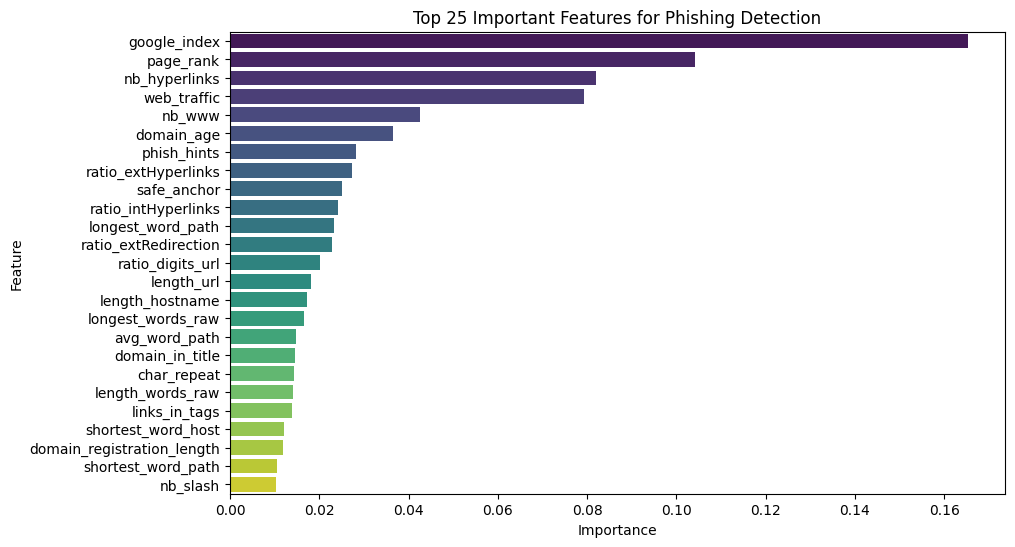

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import shap

# Load the dataset
df = pd.read_csv("/content/drive/MyDrive/dataset_3/dataset_phishing.csv")

# Separate features and target
X = df.drop(columns=['status','url'])
y = df['status']

# Handle missing values (if any)
X = X.fillna(X.median())

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Extract feature importance
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': rf_model.feature_importances_})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
# Get top features as a list
top_features_list = feature_importance['Feature'].tolist()
print("Top Features List:", top_features_list)
# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance[:25], palette='viridis')
plt.title('Top 25 Important Features for Phishing Detection')
plt.show()




In [ ]:
print("Total no of columns : ",df.shape[1])
# Separate binary and numerical features
binary_features = [col for col in df.columns if df[col].nunique() == 2 and col != "status"]
numerical_features = [col for col in df.select_dtypes(include=['number']).columns if col not in binary_features + ["status"]]

print("Binary Features:", len(binary_features))
print("Binary Features:", binary_features)
print("Numerical Features:", numerical_features)
print("Numerical Features:", len(numerical_features))


Total no of columns :  89
Binary Features: 31
Binary Features: ['ip', 'nb_tilde', 'nb_star', 'nb_dslash', 'https_token', 'punycode', 'port', 'tld_in_path', 'tld_in_subdomain', 'abnormal_subdomain', 'prefix_suffix', 'random_domain', 'shortening_service', 'path_extension', 'nb_external_redirection', 'domain_in_brand', 'brand_in_subdomain', 'brand_in_path', 'suspecious_tld', 'login_form', 'external_favicon', 'iframe', 'popup_window', 'onmouseover', 'right_clic', 'empty_title', 'domain_in_title', 'domain_with_copyright', 'whois_registered_domain', 'dns_record', 'google_index']
Numerical Features: ['length_url', 'length_hostname', 'nb_dots', 'nb_hyphens', 'nb_at', 'nb_qm', 'nb_and', 'nb_or', 'nb_eq', 'nb_underscore', 'nb_percent', 'nb_slash', 'nb_colon', 'nb_comma', 'nb_semicolumn', 'nb_dollar', 'nb_space', 'nb_www', 'nb_com', 'http_in_path', 'ratio_digits_url', 'ratio_digits_host', 'nb_subdomains', 'nb_redirection', 'length_words_raw', 'char_repeat', 'shortest_words_raw', 'shortest_word_ho

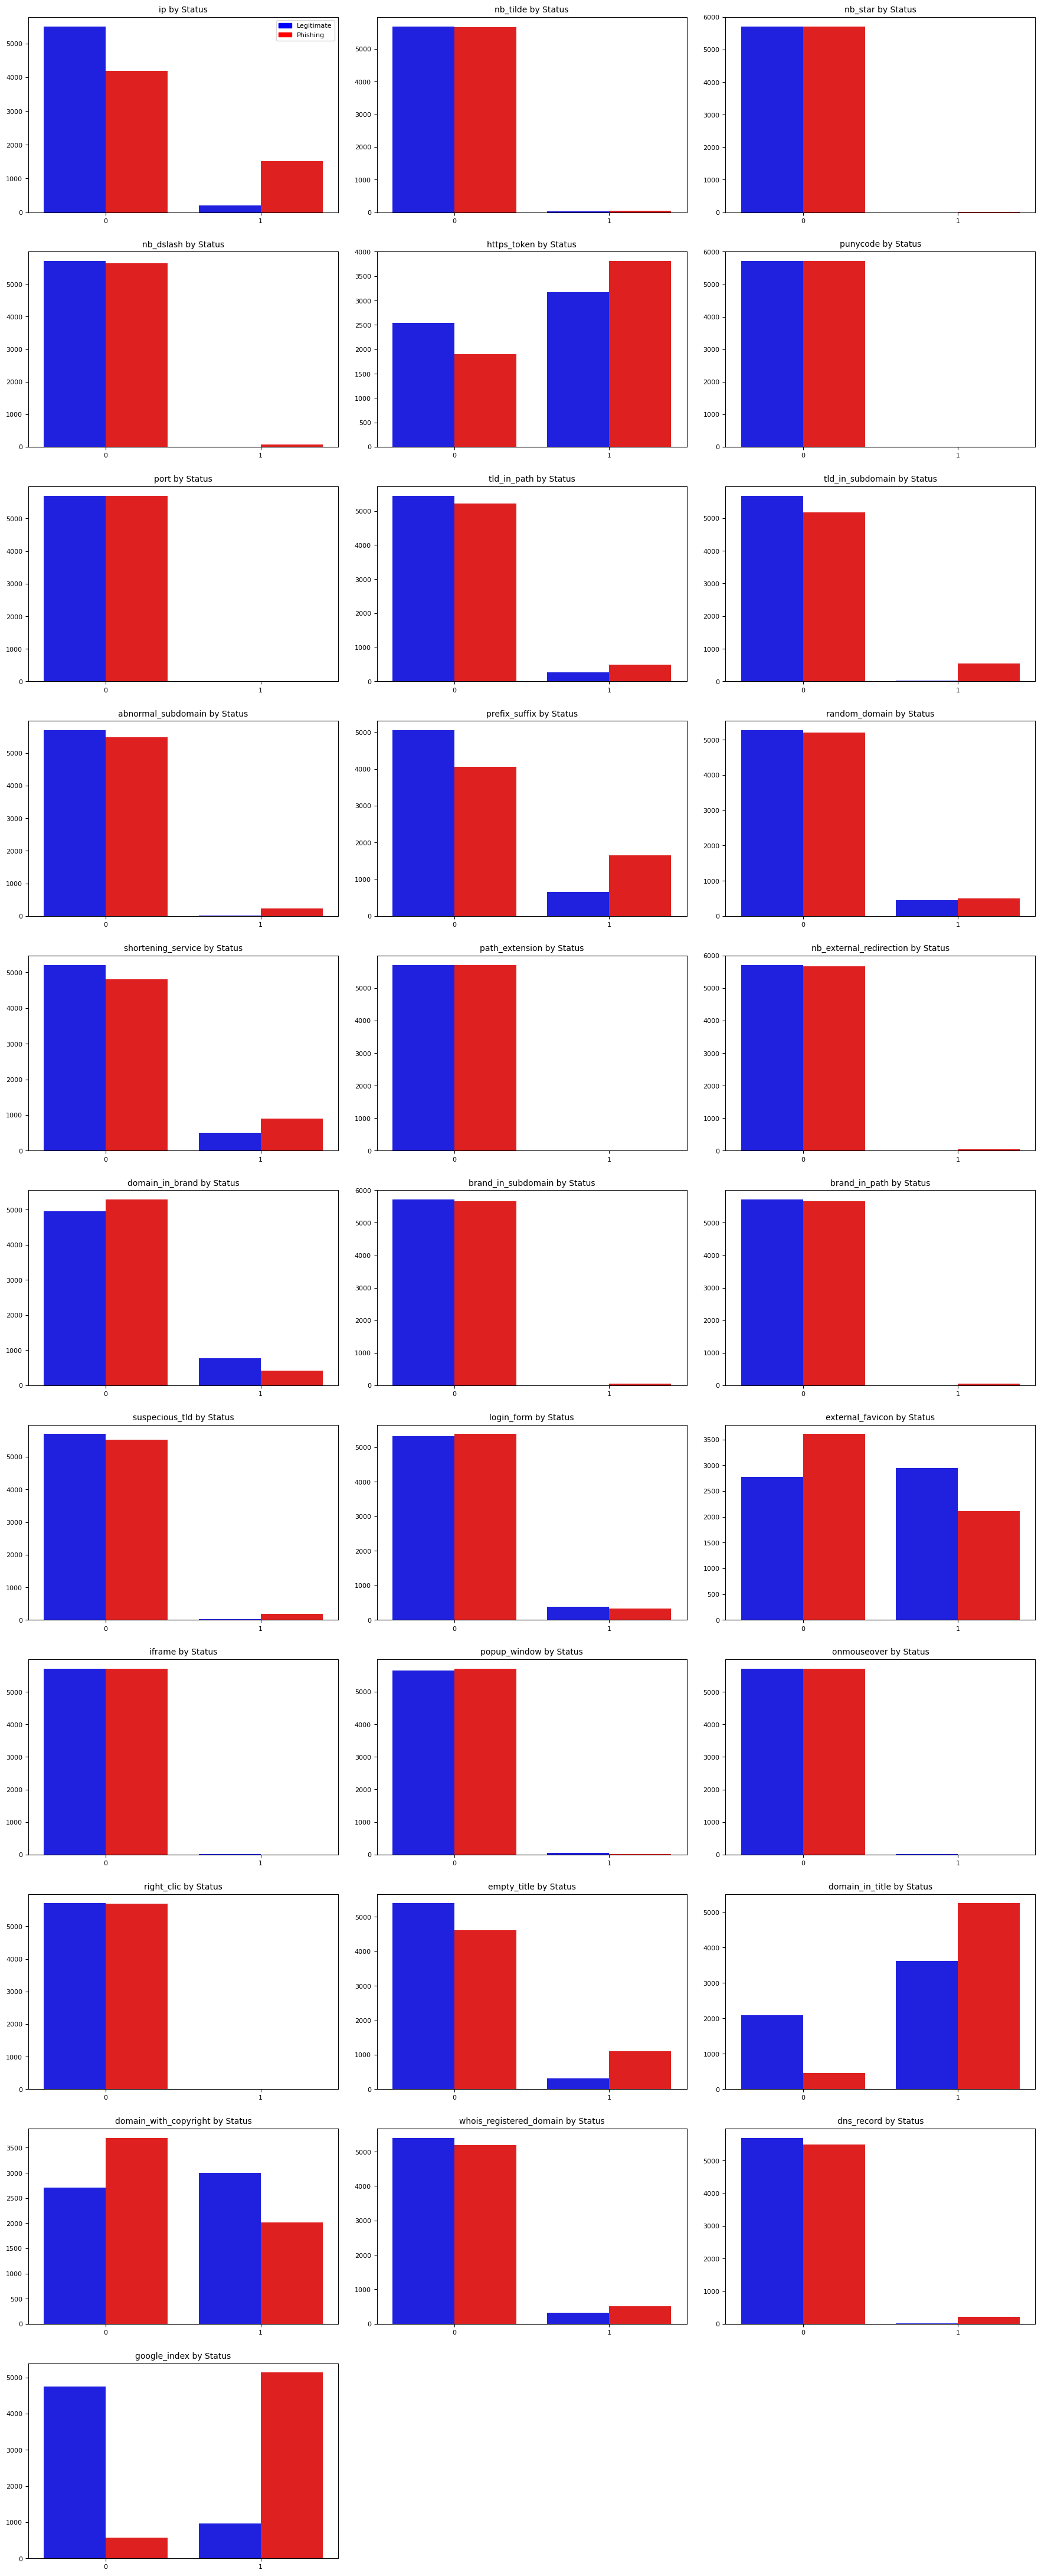

In [ ]:
import math
from matplotlib.patches import Patch

binary_features=['ip', 'nb_tilde', 'nb_star', 'nb_dslash', 'https_token', 'punycode', 'port',
                 'tld_in_path', 'tld_in_subdomain', 'abnormal_subdomain', 'prefix_suffix',
                 'random_domain', 'shortening_service', 'path_extension', 'nb_external_redirection',
                 'domain_in_brand', 'brand_in_subdomain', 'brand_in_path', 'suspecious_tld', 'login_form',
                 'external_favicon', 'iframe', 'popup_window', 'onmouseover', 'right_clic', 'empty_title',
                 'domain_in_title', 'domain_with_copyright', 'whois_registered_domain', 'dns_record', 'google_index']
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
import math

# Define label mapping
label_map = {0: "Legitimate", 1: "Phishing"}
palette = {0: "blue", 1: "red"}

# Grid setup
cols = 3
rows = math.ceil(len(binary_features) / cols)
plt.figure(figsize=(cols * 6, rows * 4))  # Bigger figure scaling

# Plot
for i, col in enumerate(binary_features, 1):
    plt.subplot(rows, cols, i)
    sns.countplot(x=col, hue="status", data=df, palette=palette)
    plt.title(f"{col} by Status", fontsize=10)
    plt.xlabel("")
    plt.ylabel("")
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)

    handles = [Patch(color=palette[k], label=label_map[k]) for k in sorted(label_map)]
    if i == 1:  # Show legend only on first subplot to save space
        plt.legend(handles=handles, loc='upper right', fontsize=8)
    else:
        plt.legend([], [], frameon=False)

plt.tight_layout(pad=2)
plt.show()


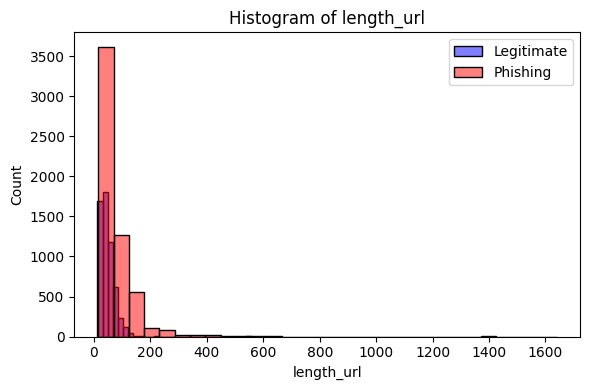

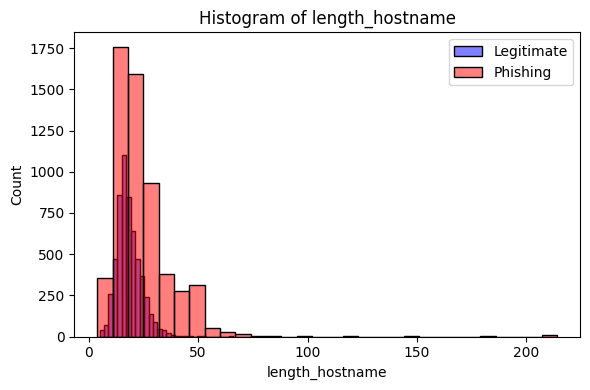

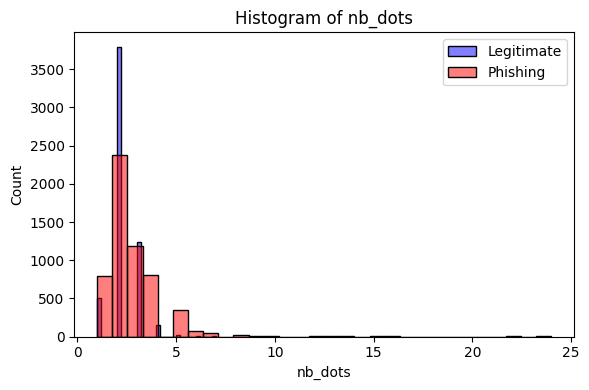

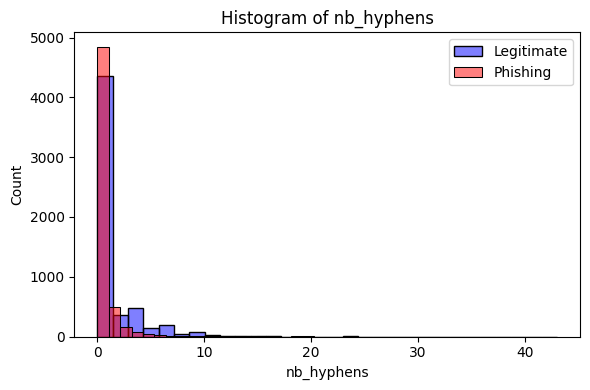

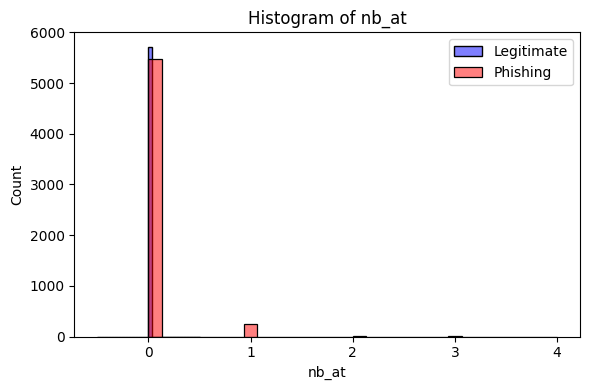

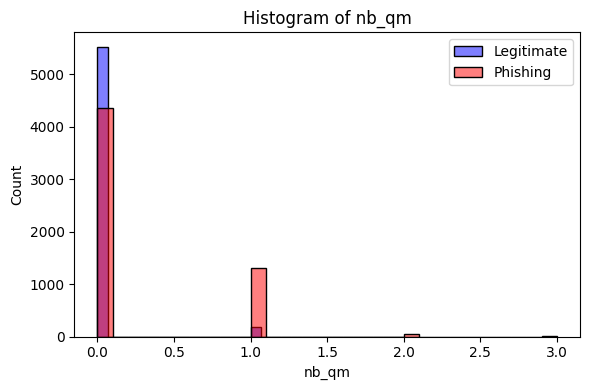

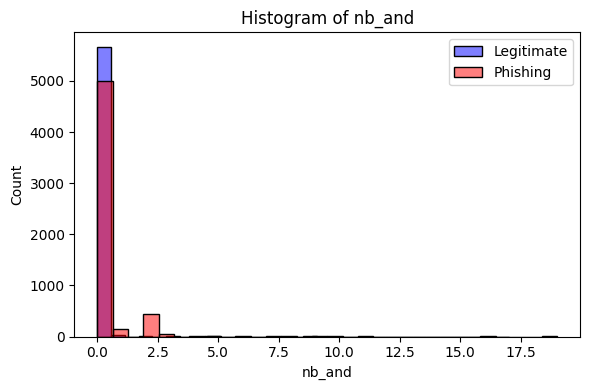

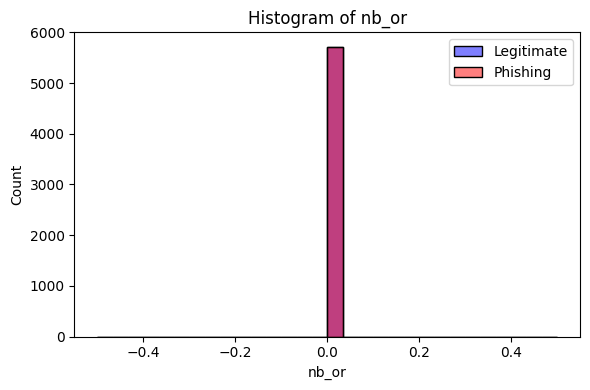

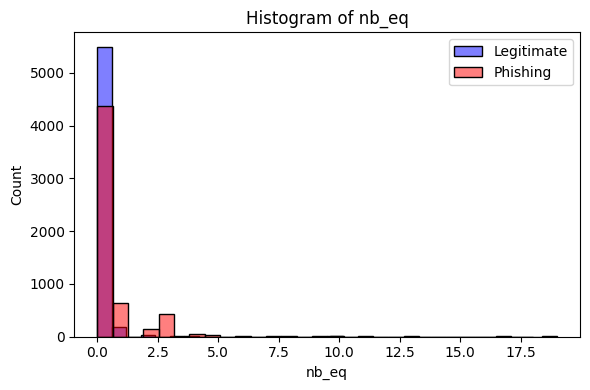

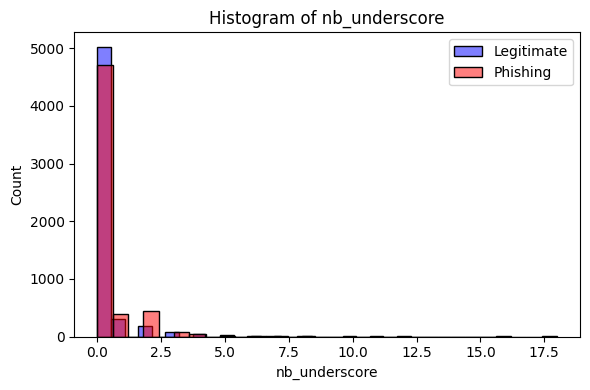

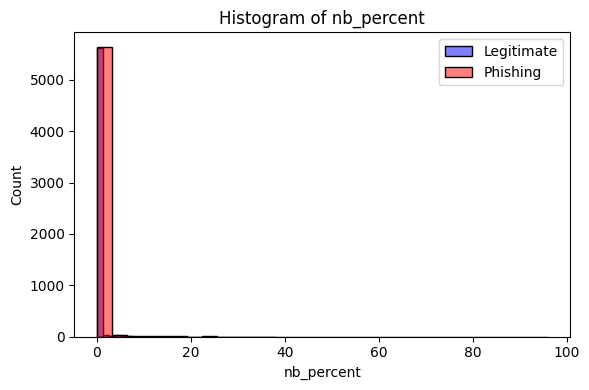

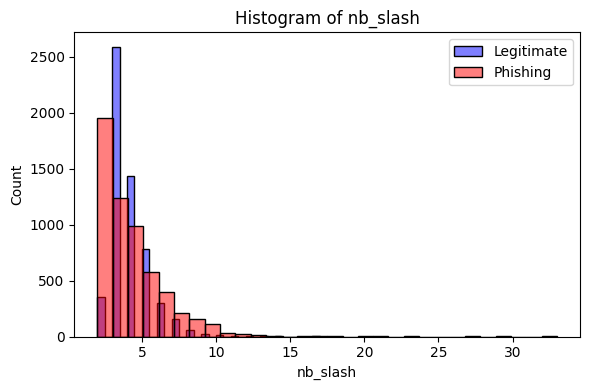

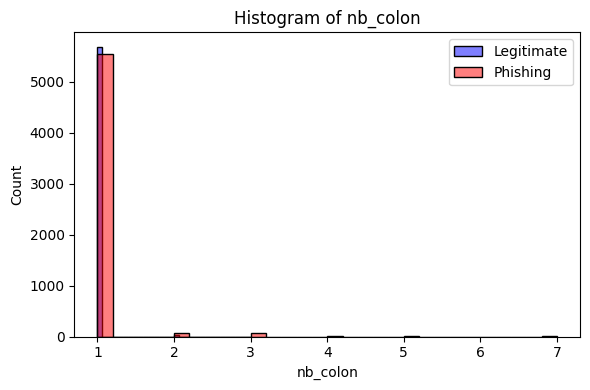

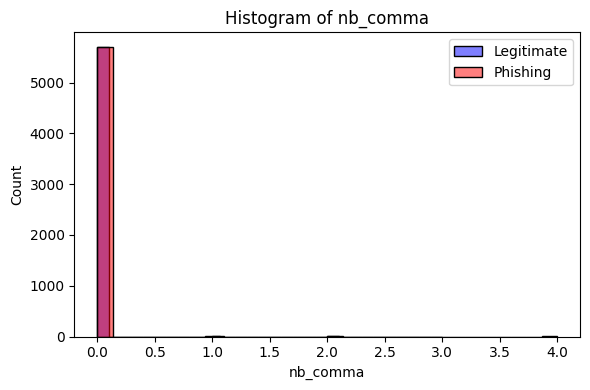

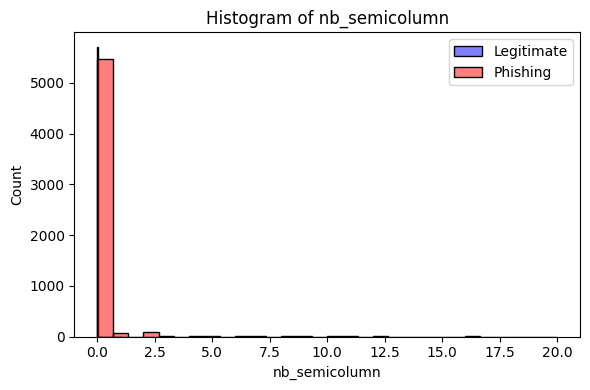

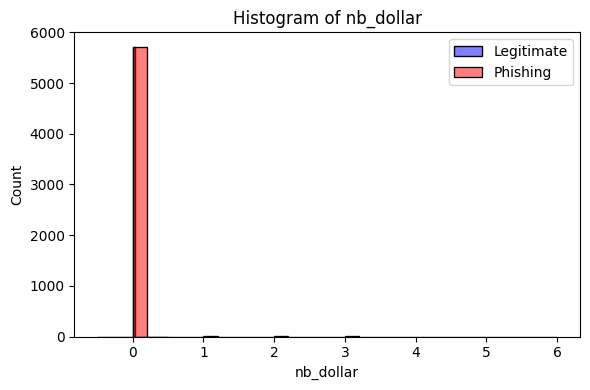

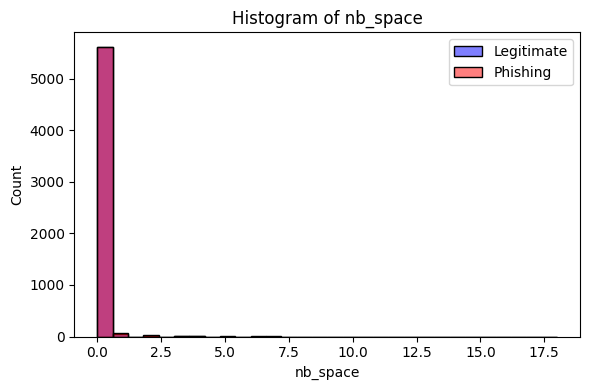

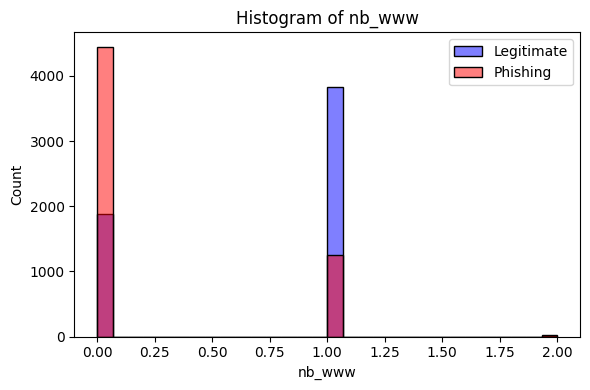

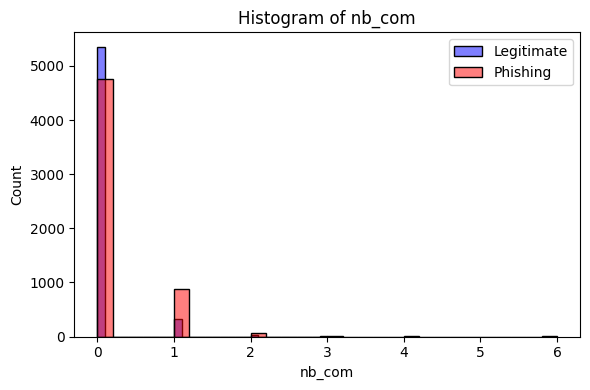

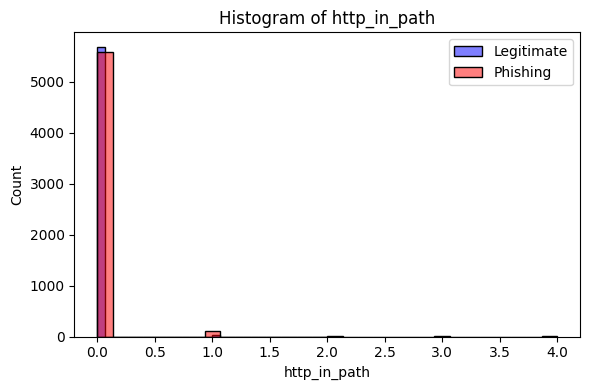

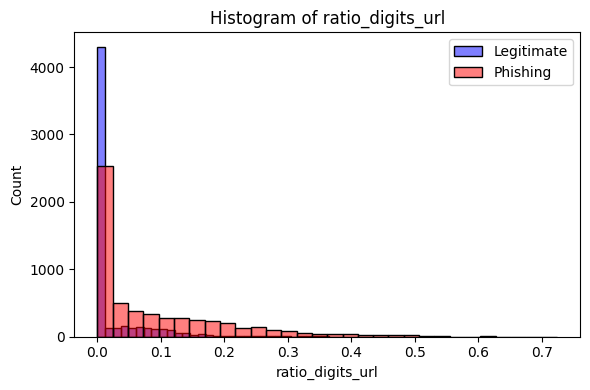

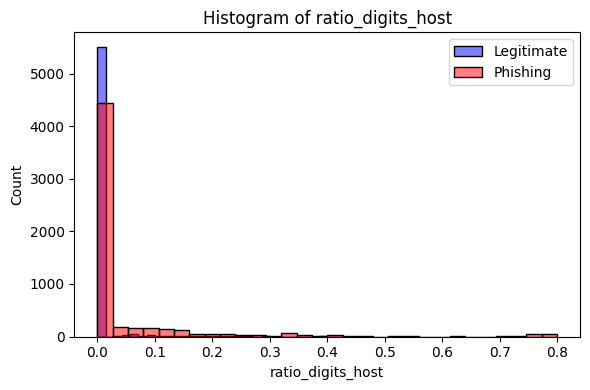

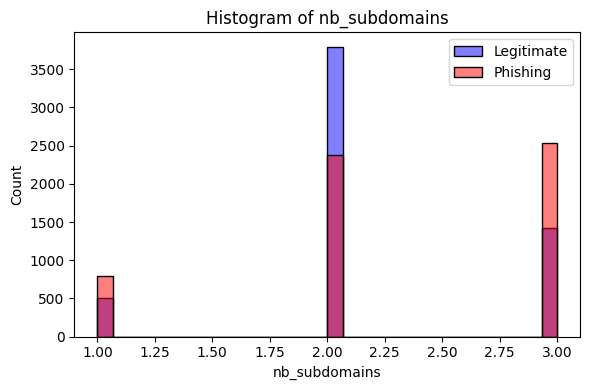

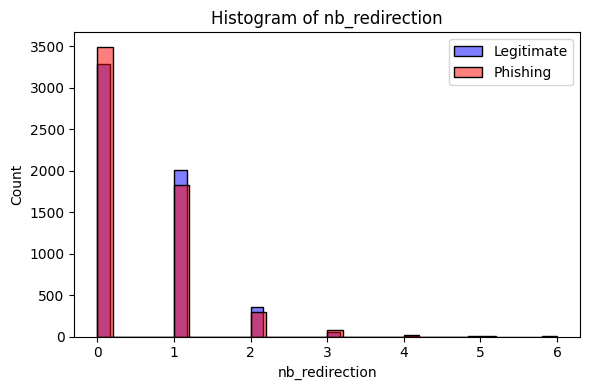

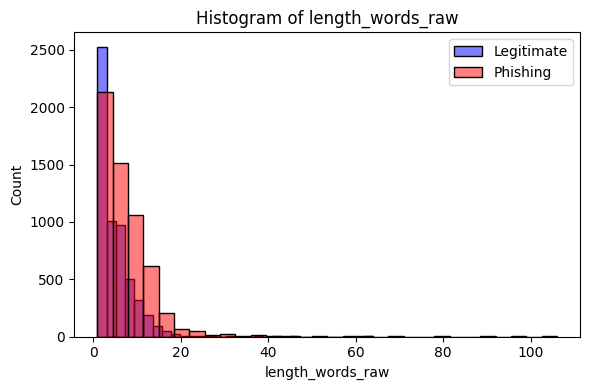

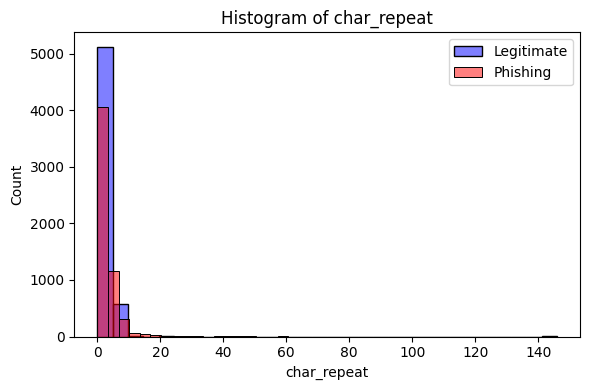

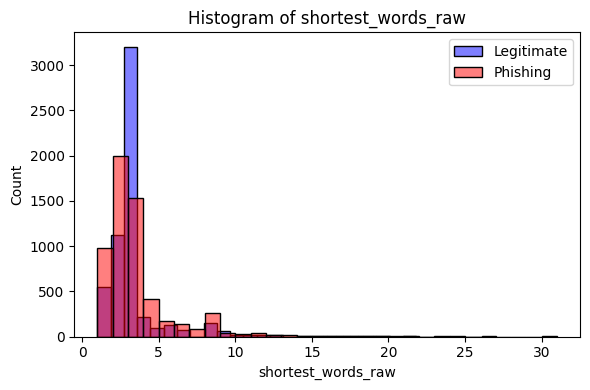

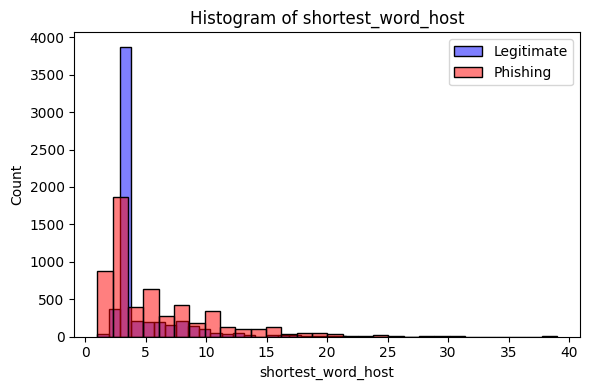

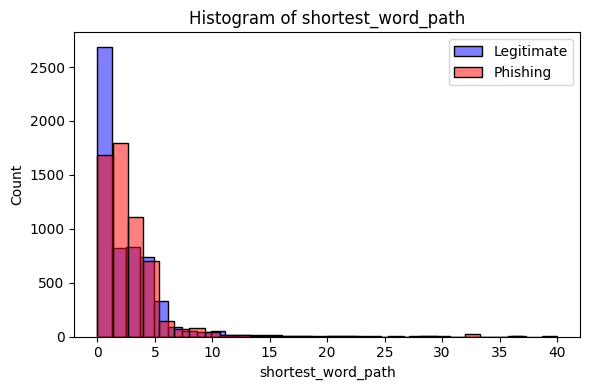

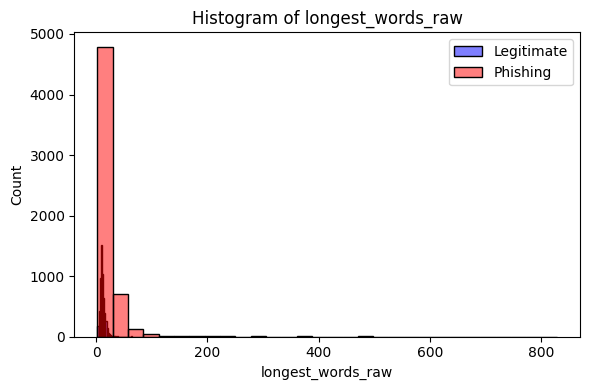

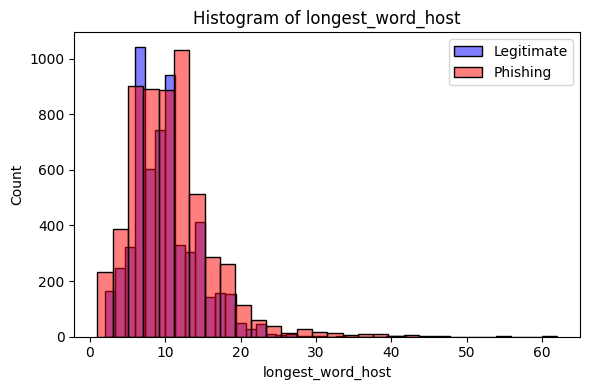

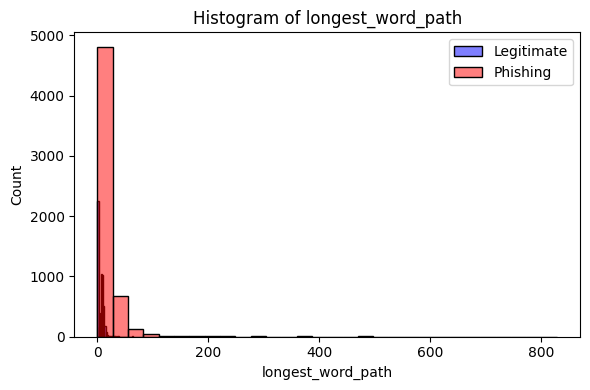

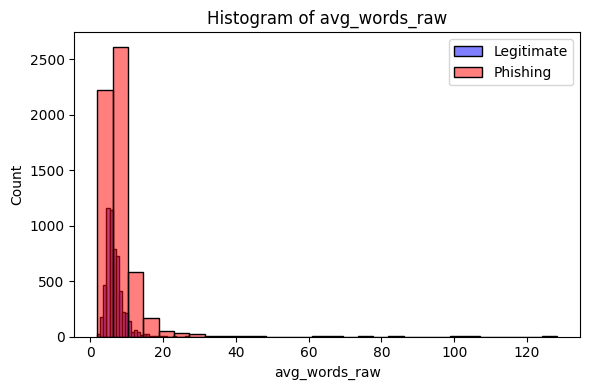

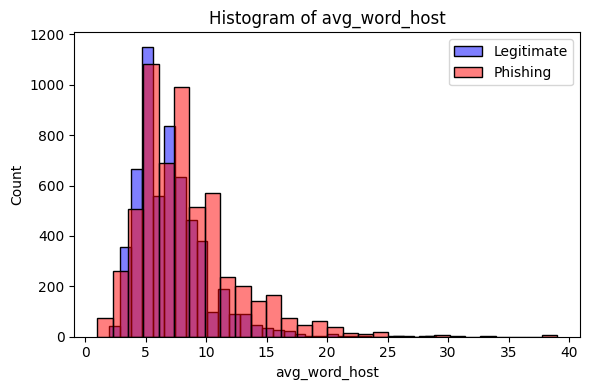

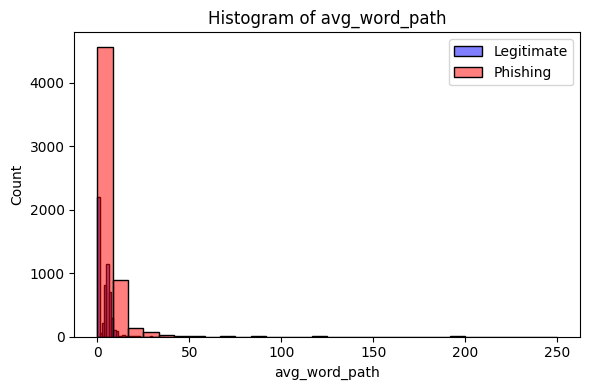

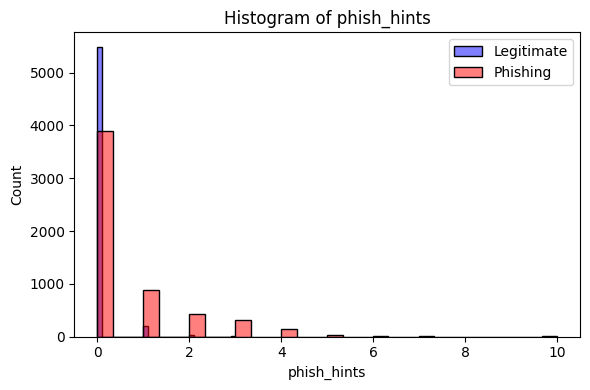

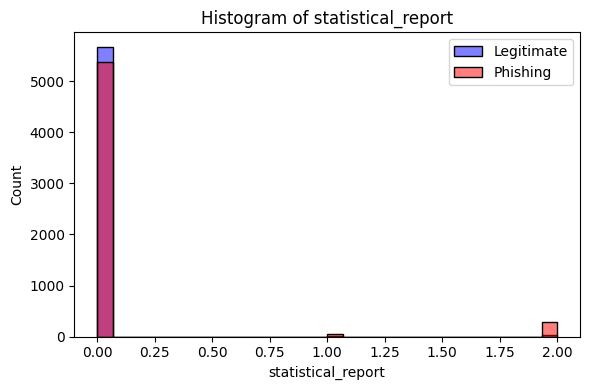

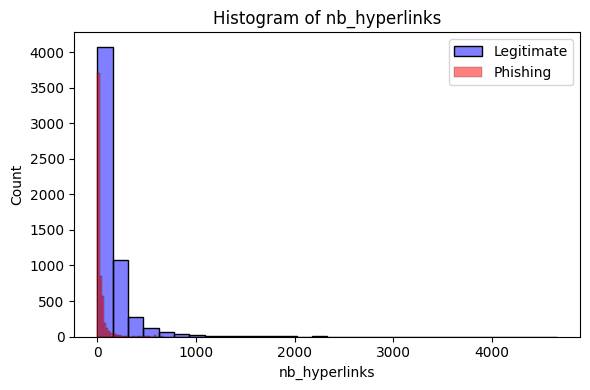

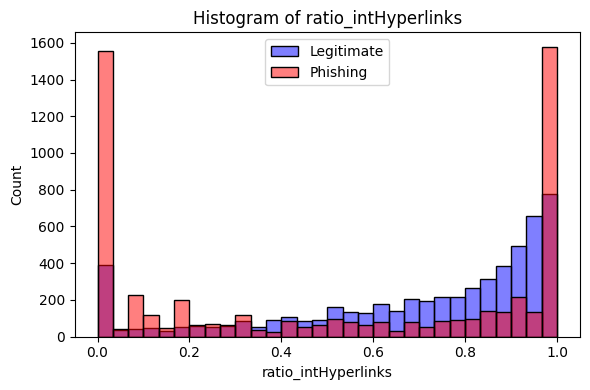

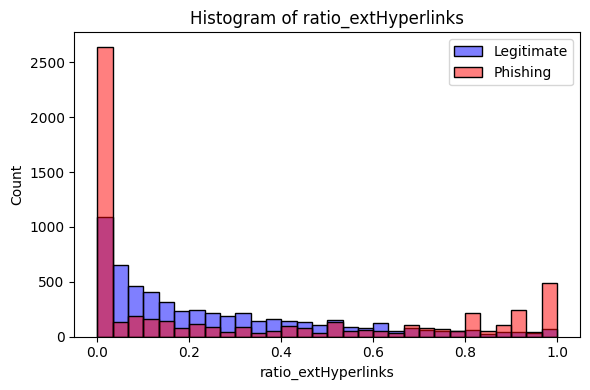

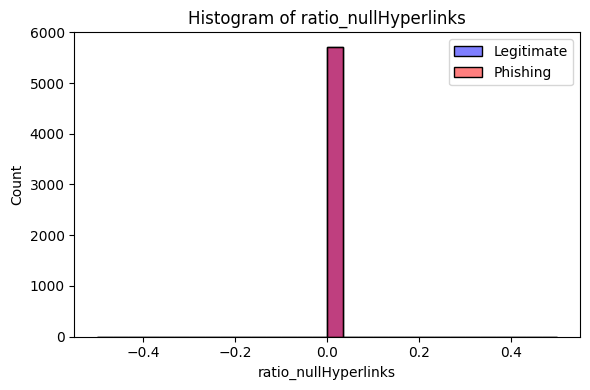

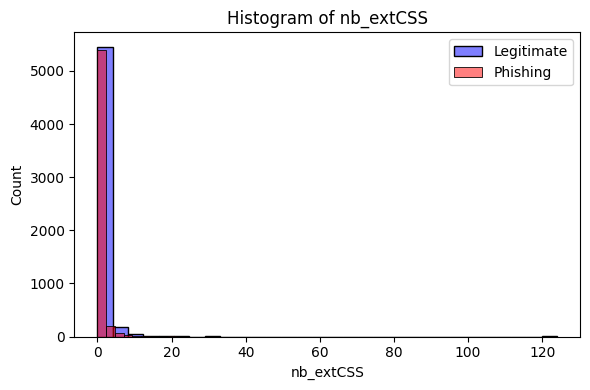

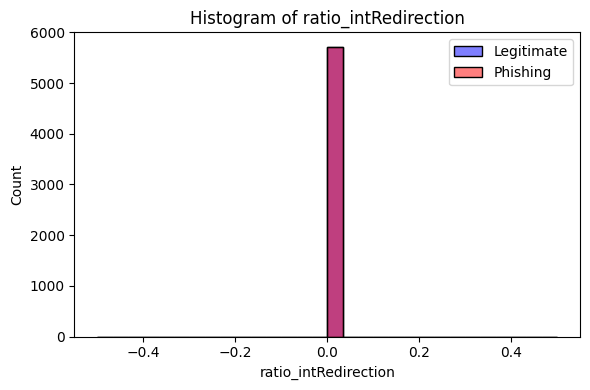

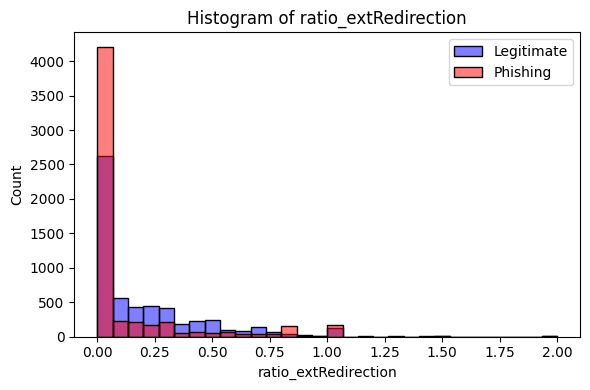

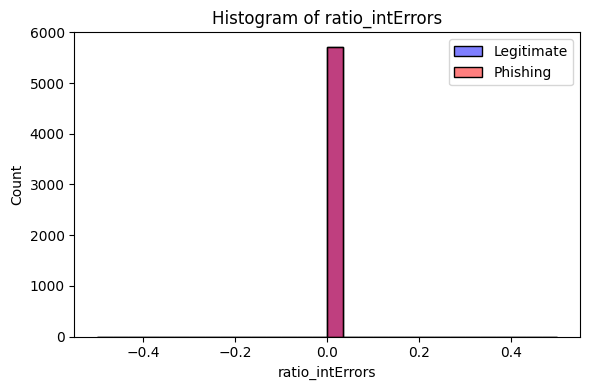

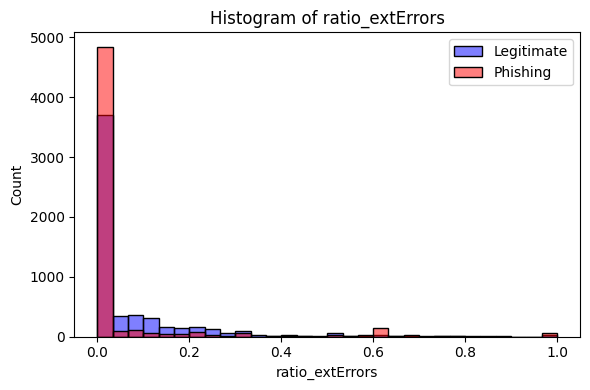

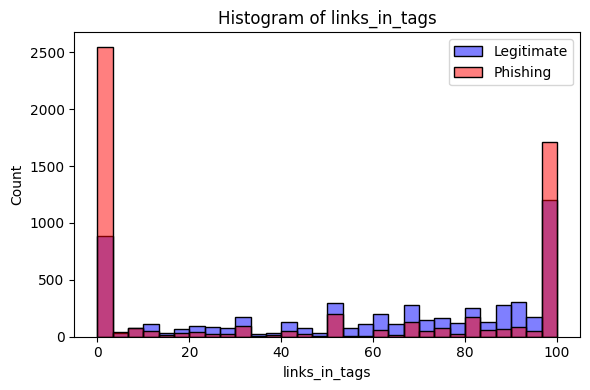

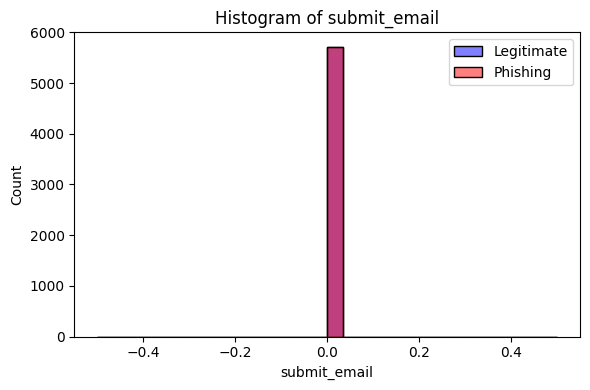

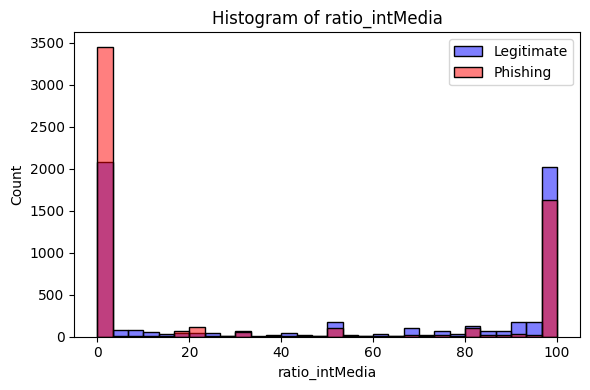

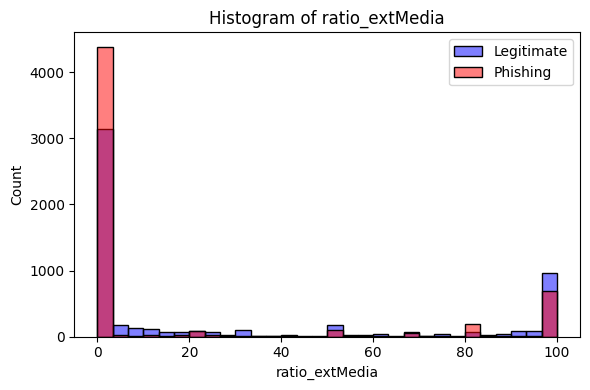

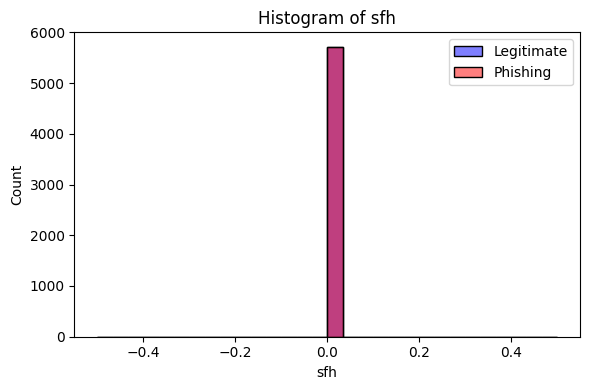

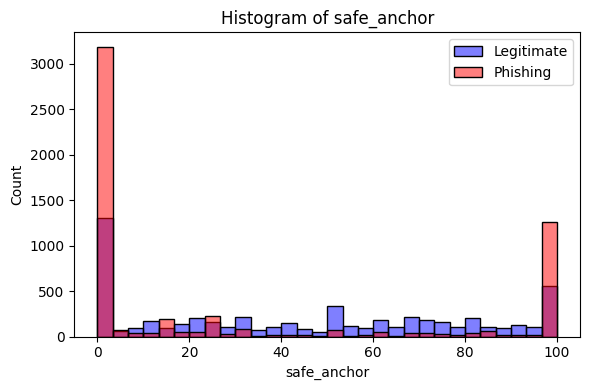

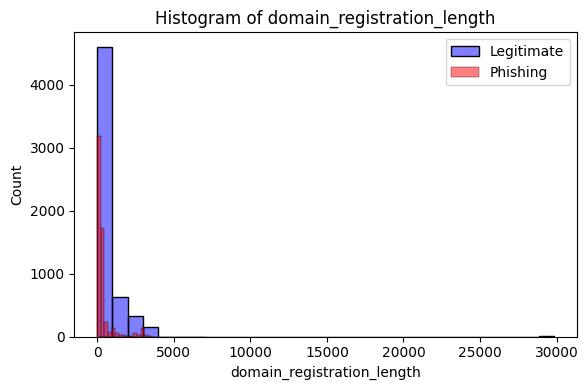

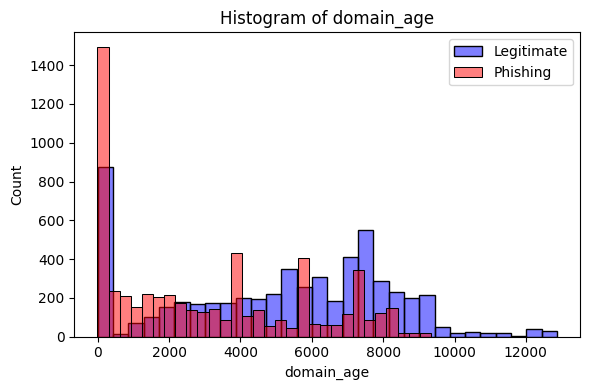

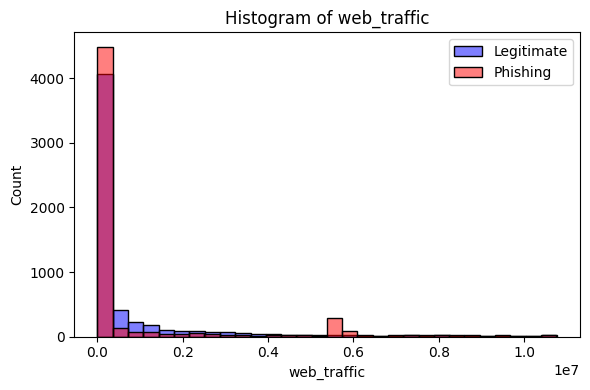

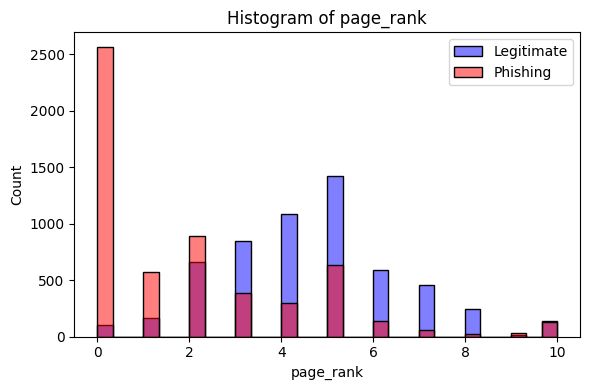

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# List of selected numerical features
num_features = ['length_url', 'length_hostname', 'nb_dots', 'nb_hyphens', 'nb_at', 'nb_qm', 'nb_and',
                'nb_or', 'nb_eq', 'nb_underscore', 'nb_percent', 'nb_slash', 'nb_colon', 'nb_comma',
                'nb_semicolumn', 'nb_dollar', 'nb_space', 'nb_www', 'nb_com', 'http_in_path', 'ratio_digits_url',
                'ratio_digits_host', 'nb_subdomains', 'nb_redirection', 'length_words_raw', 'char_repeat', 'shortest_words_raw',
                'shortest_word_host', 'shortest_word_path', 'longest_words_raw', 'longest_word_host', 'longest_word_path',
                'avg_words_raw', 'avg_word_host', 'avg_word_path', 'phish_hints', 'statistical_report', 'nb_hyperlinks',
                'ratio_intHyperlinks', 'ratio_extHyperlinks', 'ratio_nullHyperlinks', 'nb_extCSS', 'ratio_intRedirection',
                'ratio_extRedirection', 'ratio_intErrors', 'ratio_extErrors', 'links_in_tags', 'submit_email', 'ratio_intMedia',
                'ratio_extMedia', 'sfh', 'safe_anchor', 'domain_registration_length', 'domain_age', 'web_traffic', 'page_rank']

for col in num_features:
    plt.figure(figsize=(6, 4))  # Smaller figure size

    sns.histplot(df[df["status"] == 0][col], label="Legitimate", bins=30, alpha=0.5, color="blue")
    sns.histplot(df[df["status"] == 1][col], label="Phishing", bins=30, alpha=0.5, color="red")

    plt.legend()
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.title(f"Histogram of {col}")
    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()




<ipython-input-18-f5d5c98b5bfb>:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
<ipython-input-18-f5d5c98b5bfb>:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
<ipython-input-18-f5d5c98b5bfb>:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
<ipython-input-18-f5d5c98b5bfb>:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
<ipython-input-18-f5d5c98b5bfb>:17: UserWarning: No artists with labels found to put in legend.  Note that artists w

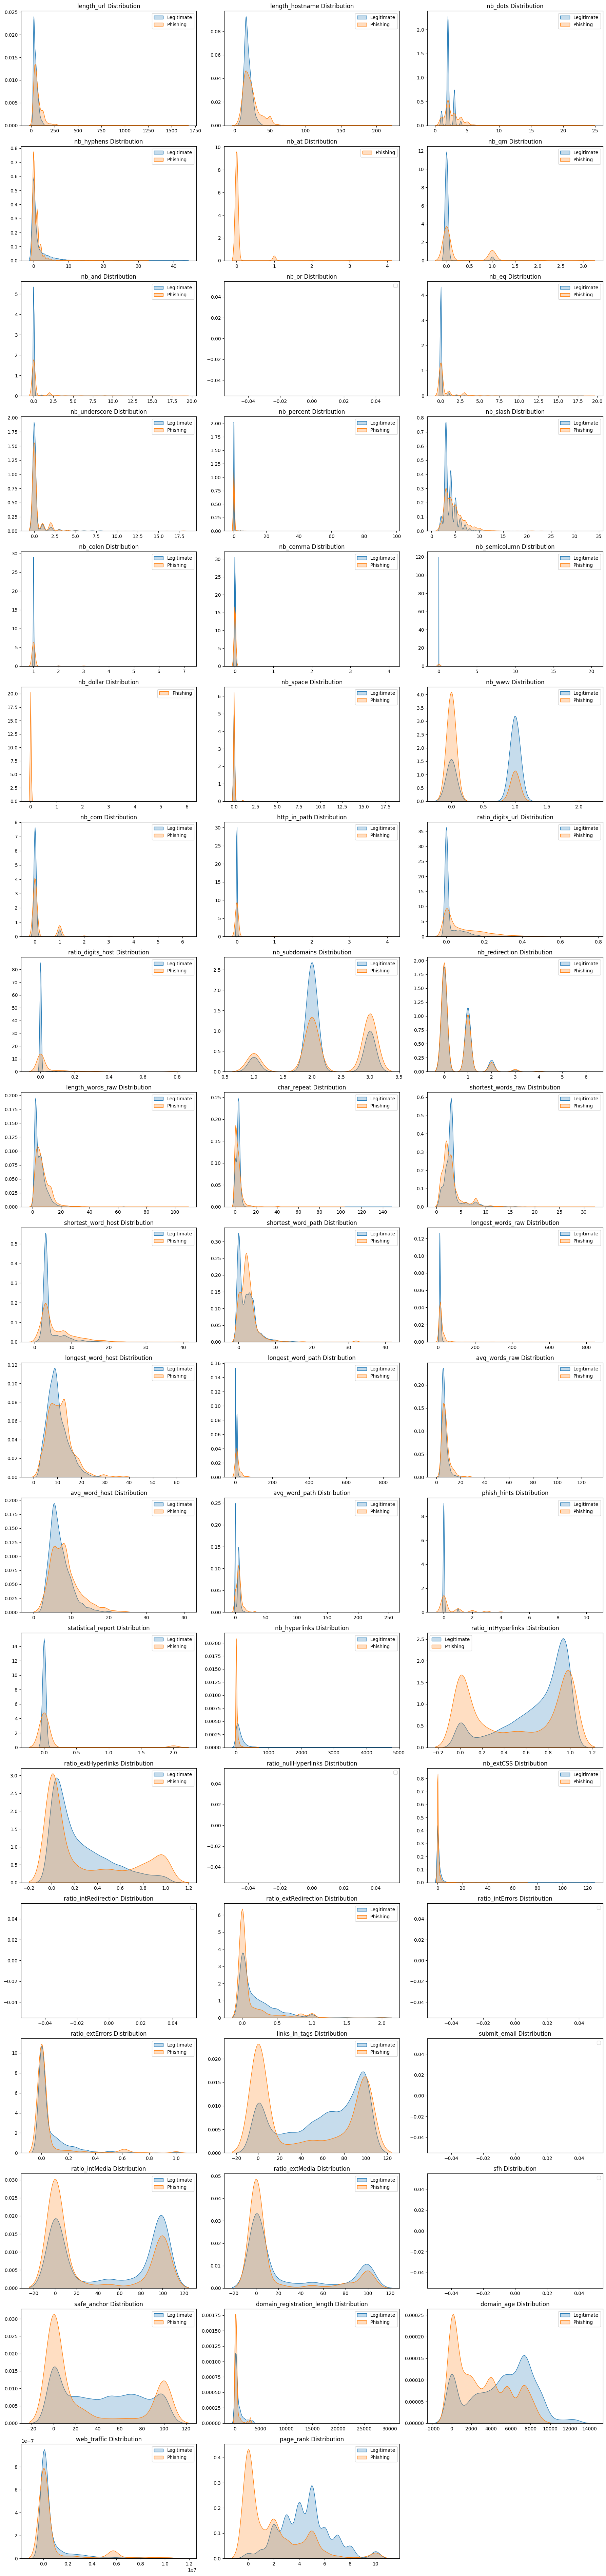

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Grid setup
cols = 3
rows = math.ceil(len(numerical_features) / cols)
plt.figure(figsize=(6 * cols, 4 * rows))  # Larger plot size

for i, col in enumerate(numerical_features, 1):
    plt.subplot(rows, cols, i)
    sns.kdeplot(df[df["status"] == 0][col], label="Legitimate", fill=True, warn_singular=False)
    sns.kdeplot(df[df["status"] == 1][col], label="Phishing", fill=True, warn_singular=False)
    plt.title(f"{col} Distribution")
    plt.xlabel("")
    plt.ylabel("")
    plt.legend()

plt.tight_layout()
plt.show()



In [ ]:
df.drop(columns=['url','nb_or','ratio_nullHyperlinks','ratio_intRedirection','ratio_intErrors','submit_email','sfh'], axis=1, inplace=True)

In [ ]:
df.drop(columns=['punycode','port','path_extension','iframe','onmouseover','right_clic'], axis=1, inplace=True)

In [ ]:
len(df.columns)

76

In [ ]:
import numpy as np
import pandas as pd
import sys
from sklearn.feature_selection import mutual_info_classif

# Load dataset
#df = pd.read_csv("/content/drive/MyDrive/dataset_3/dataset_phishing.csv")
# Ensure 'label' is not part of the features
feature_columns = [col for col in df.columns if col not in ["status","url"]]
X_data = df[feature_columns].values  # Feature matrix
y_data = df["status"].values  # Labels

# Hyperparameters (Reduced for Speed)
N = 60    # Reduced population size
T = 1000   # Reduced iterations
Dim = X_data.shape[1]  # Number of features
alpha = 0.9
beta = 0.1

# Initialize rabbit population (binary feature selection vectors)
X = np.random.randint(2, size=(N, Dim))

# Precompute Mutual Information for all features
mi_scores = mutual_info_classif(X_data, y_data)

# Fitness function using precomputed MI
def calculate_fitness(feature_vector):
    selected_features = np.where(feature_vector == 1)[0]
    if len(selected_features) == 0:
        return float('-inf')  # Penalize empty feature sets
    mi_score = np.sum(mi_scores[selected_features])
    return alpha * mi_score - beta * (len(selected_features) / Dim)

# Initialize best solution
fitness_values = np.array([calculate_fitness(X[i]) for i in range(N)])
best_idx = np.argmax(fitness_values)
best_fitness = fitness_values[best_idx]
X_star = X[best_idx].copy()

# Rabbit Optimization Algorithm (ROA)
for t in range(T):
    for i in range(N):
        # Compute fitness after modification
        fitness = calculate_fitness(X[i])

        # Update best solution **AFTER** computing fitness
        if fitness > best_fitness:
            best_fitness = fitness
            X_star = X[i].copy()

        # Exploration Phase
        if np.random.rand() < 4 * (1 - t / T) * np.log(1 / np.random.rand()):
            j = np.random.randint(N)
            step_size = np.random.uniform(-1, 1, size=Dim)
            X[i] = np.clip(X[j] + step_size * (X[i] - X[j]), 0, 1)

        # Exploitation Phase
        else:
            step_size = np.random.uniform(-1, 1, size=Dim)
            X[i] = np.clip(X[i] + step_size * (X_star - X[i]), 0, 1)

        # Apply sigmoid binarization
        X[i] = np.where(1 / (1 + np.exp(-X[i])) > 0.5, 1, 0)

        # Update fitness values **AFTER** modifying X[i]
        fitness_values[i] = calculate_fitness(X[i])

    # Print iteration progress in real-time
    print(f"\rIteration {t+1}/{T} - Best Fitness: {best_fitness:.4f} - Selected Features: {np.sum(X_star)}", end="")
    sys.stdout.flush()  # Force console update

# Print final results
print("\n\nFinal Results:")
selected_features = np.where(X_star == 1)[0]
print("Best feature vector:", X_star)
print("Best fitness score:", best_fitness)
print("Selected features (indices):", selected_features)
print("Number of selected features:", len(selected_features))
print("Selected feature names:", [feature_columns[i] for i in selected_features])


Iteration 1000/1000 - Best Fitness: 2.9335 - Selected Features: 44

Final Results:
Best feature vector: [1 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 0 1 0 0 0 0 1 0 1 0 0 0 0 1 1 0 0 1 0
 1 0 1 1 1 1 1 1 1 1 0 1 1 1 0 1 0 1 0 1 0 1 1 1 1 0 1 0 1 0 0 1 1 1 1 1 1
 1]
Best fitness score: 2.933503577825162
Selected features (indices): [ 0  3  4  5  6  7  8  9 16 17 19 24 26 31 32 35 37 39 40 41 42 43 44 45
 46 48 49 50 52 54 56 58 59 60 61 63 65 68 69 70 71 72 73 74]
Number of selected features: 44
Selected feature names: ['length_url', 'nb_dots', 'nb_hyphens', 'nb_at', 'nb_qm', 'nb_and', 'nb_eq', 'nb_underscore', 'nb_semicolumn', 'nb_dollar', 'nb_www', 'ratio_digits_url', 'tld_in_path', 'random_domain', 'shortening_service', 'length_words_raw', 'shortest_words_raw', 'shortest_word_path', 'longest_words_raw', 'longest_word_host', 'longest_word_path', 'avg_words_raw', 'avg_word_host', 'avg_word_path', 'phish_hints', 'brand_in_subdomain', 'brand_in_path', 'suspecious_tld', 'nb_hyperlinks', 'ratio_ex

Selected feature names= ['length_url', 'nb_dots', 'nb_hyphens', 'nb_at', 'nb_qm', 'nb_and', 'nb_eq', 'nb_underscore', 'nb_semicolumn', 'nb_dollar', 'nb_www', 'ratio_digits_url', 'tld_in_path', 'random_domain', 'shortening_service', 'length_words_raw', 'shortest_words_raw', 'shortest_word_path', 'longest_words_raw', 'longest_word_host', 'longest_word_path', 'avg_words_raw', 'avg_word_host', 'avg_word_path', 'phish_hints', 'brand_in_subdomain', 'brand_in_path', 'suspecious_tld', 'nb_hyperlinks', 'ratio_extHyperlinks', 'ratio_extRedirection', 'login_form', 'external_favicon', 'links_in_tags', 'ratio_intMedia', 'popup_window', 'empty_title', 'whois_registered_domain', 'domain_registration_length', 'domain_age', 'web_traffic', 'dns_record', 'google_index', 'page_rank']



In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
# Load dataset
#df = pd.read_csv("/content/drive/MyDrive/dataset_3/dataset_phishing.csv")

feature_columns = [feature_columns[i] for i in selected_features]

X_data = df[feature_columns].values  # Feature matrix
y_data = df["status"].values  # Labels
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

# Train a classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print(f"\nModel Accuracy with Random Forest: {acc * 100:.2f}%")
from xgboost import XGBClassifier

xgb_model = XGBClassifier(n_estimators=500, learning_rate=0.01, max_depth=10, random_state=42)
xgb_model.fit(X_data, y_data)

y_pred = xgb_model.predict(X_data)
acc = accuracy_score(y_data, y_pred)
print(f"XGBoost Model Accuracy: {acc * 100:.2f}%")
from sklearn.metrics import classification_report, confusion_matrix
print("random forest")
# Predict on the test set
y_pred = clf.predict(X_test)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Compute classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

print("xgb model")
# Predict on the test set
y_pred = xgb_model.predict(X_test)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Compute classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)




Model Accuracy with Random Forest: 96.50%
XGBoost Model Accuracy: 99.48%
random forest
Confusion Matrix:
 [[1121   36]
 [  44 1085]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.97      0.97      1157
           1       0.97      0.96      0.96      1129

    accuracy                           0.97      2286
   macro avg       0.97      0.96      0.96      2286
weighted avg       0.97      0.97      0.97      2286

xgb model
Confusion Matrix:
 [[1154    3]
 [   2 1127]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1157
           1       1.00      1.00      1.00      1129

    accuracy                           1.00      2286
   macro avg       1.00      1.00      1.00      2286
weighted avg       1.00      1.00      1.00      2286



In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# STEP 1: Scale your features using RobustScaler
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# STEP 2: Create and train the MLP model
mlp = MLPClassifier(
    hidden_layer_sizes=(256, 128, 64),
    max_iter=1000,
    activation='relu',
    solver='adam',
    early_stopping=True,
    random_state=42,
    verbose=True  # Optional: shows training progress
)

mlp.fit(X_train_scaled, y_train)

# STEP 3: Make predictions
y_pred = mlp.predict(X_test_scaled)

# STEP 4: Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

# STEP 5: Print results
print(f"MLP Model Accuracy (RobustScaler): {accuracy * 100:.2f}%\n")
print("Confusion Matrix:")
print(cm)
print("\nClassification Report:")
print(report)


Iteration 1, loss = 0.34730069
Validation score: 0.938798
Iteration 2, loss = 0.17227185
Validation score: 0.944262
Iteration 3, loss = 0.14199359
Validation score: 0.940984
Iteration 4, loss = 0.13705950
Validation score: 0.939891
Iteration 5, loss = 0.12393818
Validation score: 0.946448
Iteration 6, loss = 0.11527485
Validation score: 0.940984
Iteration 7, loss = 0.12207461
Validation score: 0.946448
Iteration 8, loss = 0.11029139
Validation score: 0.937705
Iteration 9, loss = 0.09640918
Validation score: 0.945355
Iteration 10, loss = 0.09077525
Validation score: 0.951913
Iteration 11, loss = 0.08611135
Validation score: 0.951913
Iteration 12, loss = 0.08408684
Validation score: 0.944262
Iteration 13, loss = 0.07373810
Validation score: 0.940984
Iteration 14, loss = 0.07332467
Validation score: 0.954098
Iteration 15, loss = 0.06587100
Validation score: 0.951913
Iteration 16, loss = 0.06027450
Validation score: 0.951913
Iteration 17, loss = 0.05675197
Validation score: 0.957377
Iterat

In [ ]:
import joblib
joblib.dump(scaler, '/content/drive/MyDrive/state3/robust_scaler.pkl')
print("Scaler saved as 'robust_scaler.pkl'")

Scaler saved as 'robust_scaler.pkl'


In [ ]:
import joblib

# Save models to disk
joblib.dump(clf, '/content/drive/MyDrive/state3/random_forest_model.pkl')        # Random Forest
joblib.dump(xgb_model, '/content/drive/MyDrive/state3/xgboost_model.pkl')        # XGBoost
joblib.dump(mlp, '/content/drive/MyDrive/state3/mlp_model.pkl')                  # MLP


['/content/drive/MyDrive/state3/mlp_model.pkl']

In [ ]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Load dataset
df = pd.read_csv("/content/drive/MyDrive/dataset_3/dataset_phishing.csv")

# Selected features
selected_features = [
    'length_url', 'nb_dots', 'nb_hyphens', 'nb_at', 'nb_qm', 'nb_and', 'nb_eq', 'nb_underscore',
    'nb_semicolumn', 'nb_dollar', 'nb_www', 'ratio_digits_url', 'tld_in_path', 'random_domain',
    'shortening_service', 'length_words_raw', 'shortest_words_raw', 'shortest_word_path',
    'longest_words_raw', 'longest_word_host', 'longest_word_path', 'avg_words_raw', 'avg_word_host',
    'avg_word_path', 'phish_hints', 'brand_in_subdomain', 'brand_in_path', 'suspecious_tld',
    'nb_hyperlinks', 'ratio_extHyperlinks', 'ratio_extRedirection', 'login_form',
    'external_favicon', 'links_in_tags', 'ratio_intMedia', 'popup_window', 'empty_title',
    'whois_registered_domain', 'domain_registration_length', 'domain_age', 'web_traffic',
    'dns_record', 'google_index', 'page_rank'
]

# Define features and target
X = df[selected_features]
y = df['status']  # Assuming the label column is named 'label'

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# LightGBM model using sklearn API
model = lgb.LGBMClassifier(
    objective='binary',
    n_estimators=100,
    random_state=42,
    verbose=-1
)

# Train the model
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Results
print(f"LightGBM Accuracy: {acc * 100:.2f}%\n")
print("Confusion Matrix:")
print(cm)
print("\nClassification Report:")
print(report)


LightGBM Accuracy: 97.11%

Confusion Matrix:
[[1121   36]
 [  30 1099]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1157
           1       0.97      0.97      0.97      1129

    accuracy                           0.97      2286
   macro avg       0.97      0.97      0.97      2286
weighted avg       0.97      0.97      0.97      2286



In [ ]:
import joblib

# Save the trained model
joblib.dump(model, "/content/drive/MyDrive/state3/lgbm_model.pkl")
print("LightGBM model saved!")


LightGBM model saved!


In [ ]:
import joblib
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Load your models
xgb_model = joblib.load("/content/drive/MyDrive/state3/xgboost_model.pkl")
rf_model = joblib.load("/content/drive/MyDrive/state3/random_forest_model.pkl")
mlp_model = joblib.load("/content/drive/MyDrive/state3/mlp_model.pkl")
lgbm_model = joblib.load("/content/drive/MyDrive/state3/lgbm_model.pkl")

# Load scaler only for MLP
scaler = joblib.load("/content/drive/MyDrive/state3/robust_scaler.pkl")

# Load dataset
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/dataset_3/dataset_phishing.csv")

# Selected features
features = ['length_url', 'nb_dots', 'nb_hyphens', 'nb_at', 'nb_qm', 'nb_and', 'nb_eq',
            'nb_underscore', 'nb_semicolumn', 'nb_dollar', 'nb_www', 'ratio_digits_url',
            'tld_in_path', 'random_domain', 'shortening_service', 'length_words_raw',
            'shortest_words_raw', 'shortest_word_path', 'longest_words_raw', 'longest_word_host',
            'longest_word_path', 'avg_words_raw', 'avg_word_host', 'avg_word_path',
            'phish_hints', 'brand_in_subdomain', 'brand_in_path', 'suspecious_tld',
            'nb_hyperlinks', 'ratio_extHyperlinks', 'ratio_extRedirection', 'login_form',
            'external_favicon', 'links_in_tags', 'ratio_intMedia', 'popup_window',
            'empty_title', 'whois_registered_domain', 'domain_registration_length',
            'domain_age', 'web_traffic', 'dns_record', 'google_index', 'page_rank']

X = df[features]
y = df['status']  # adjust if your label column is named differently

# Split data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale only for MLP
X_test_scaled = scaler.transform(X_test)

# Get probability predictions
proba_xgb = xgb_model.predict_proba(X_test)
proba_rf = rf_model.predict_proba(X_test)
proba_lgbm = lgbm_model.predict_proba(X_test)
proba_mlp = mlp_model.predict_proba(X_test_scaled)

# Average probabilities (soft voting)
avg_proba = (proba_xgb + proba_rf + proba_lgbm + proba_mlp) / 4
y_pred = np.argmax(avg_proba, axis=1)

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f" Soft Voting Ensemble Accuracy: {accuracy * 100:.2f}%\n")
print("Confusion Matrix:")
print(cm)
print("\n Classification Report:")
print(report)


 Soft Voting Ensemble Accuracy: 97.94%

Confusion Matrix:
[[1135   22]
 [  25 1104]]

 Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1157
           1       0.98      0.98      0.98      1129

    accuracy                           0.98      2286
   macro avg       0.98      0.98      0.98      2286
weighted avg       0.98      0.98      0.98      2286



/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [ ]:
import numpy as np
import joblib

class SoftVotingEnsemble:
    def __init__(self, xgb_model, rf_model, lgbm_model, mlp_model, scaler):
        self.xgb_model = xgb_model
        self.rf_model = rf_model
        self.lgbm_model = lgbm_model
        self.mlp_model = mlp_model
        self.scaler = scaler  # Only used for MLP

    def predict_proba(self, X):
        X_scaled = self.scaler.transform(X)

        proba_xgb = self.xgb_model.predict_proba(X)
        proba_rf = self.rf_model.predict_proba(X)
        proba_lgbm = self.lgbm_model.predict_proba(X)
        proba_mlp = self.mlp_model.predict_proba(X_scaled)

        avg_proba = (proba_xgb + proba_rf + proba_lgbm + proba_mlp) / 4
        return avg_proba

    def predict(self, X):
        proba = self.predict_proba(X)
        return np.argmax(proba, axis=1)

xgb_model = joblib.load("/content/drive/MyDrive/state3/xgboost_model.pkl")
rf_model = joblib.load("/content/drive/MyDrive/state3/random_forest_model.pkl")
mlp_model = joblib.load("/content/drive/MyDrive/state3/mlp_model.pkl")
lgbm_model = joblib.load("/content/drive/MyDrive/state3/lgbm_model.pkl")
scaler = joblib.load("/content/drive/MyDrive/state3/robust_scaler.pkl")

# Create the ensemble
ensemble_model = SoftVotingEnsemble(xgb_model, rf_model, lgbm_model, mlp_model, scaler)

# Save the ensemble
joblib.dump(ensemble_model, "/content/drive/MyDrive/state3/four_ensemble_soft_voting_model.pkl")


['/content/drive/MyDrive/state3/four_ensemble_soft_voting_model.pkl']

In [ ]:
df.to_csv("/content/drive/MyDrive/state3/dataset_phishing_cleaned.csv", index=False)


NameError: name 'df' is not defined

In [ ]:
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/state3/dataset_phishing_cleaned.csv")

In [ ]:
!apt update > /dev/null
!apt install chromium-chromedriver > /dev/null
!cp /usr/lib/chromium-browser/chromedriver /usr/bin
!pip install selenium tldextract tranco whois > /dev/null

import sys
sys.path.insert(0, '/usr/lib/chromium-browser/chromedriver')



W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


cp: '/usr/lib/chromium-browser/chromedriver' and '/usr/bin/chromedriver' are the same file


In [ ]:
num_features= ['length_url', 'nb_dots', 'nb_hyphens', 'nb_at', 'nb_qm', 'nb_and', 'nb_eq', 'nb_underscore', 'nb_semicolumn', 'nb_dollar', 'nb_www', 'ratio_digits_url', 'tld_in_path', 'random_domain', 'shortening_service', 'length_words_raw', 'shortest_words_raw', 'shortest_word_path', 'longest_words_raw', 'longest_word_host', 'longest_word_path', 'avg_words_raw', 'avg_word_host', 'avg_word_path', 'phish_hints', 'brand_in_subdomain', 'brand_in_path', 'suspecious_tld', 'nb_hyperlinks', 'ratio_extHyperlinks', 'ratio_extRedirection', 'login_form', 'external_favicon', 'links_in_tags', 'ratio_intMedia', 'popup_window', 'empty_title', 'whois_registered_domain', 'domain_registration_length', 'domain_age', 'web_traffic', 'dns_record', 'google_index', 'page_rank']

In [ ]:
# Group by the target column and calculate min and max
min_max_by_target = df.groupby('status')[num_features].agg(['min', 'max'])

# Display the result
print(min_max_by_target)


       length_url       nb_dots     nb_hyphens     nb_at     nb_qm     nb_and  \
              min   max     min max        min max   min max   min max    min   
status                                                                          
0              12   557       1   7          0  43     0   0     0   2      0   
1              15  1641       1  24          0  32     0   4     0   3      0   

           nb_eq     nb_underscore     nb_semicolumn     nb_dollar     nb_www  \
       max   min max           min max           min max       min max    min   
status                                                                          
0       17     0  18             0  16             0   1         0   0      0   
1       19     0  19             0  18             0  20         0   6      0   

           ratio_digits_url           tld_in_path     random_domain      \
       max              min       max         min max           min max   
status                                

In [ ]:
def extract_length_url(url):
    return len(url)

def extract_nb_dots(url):
    return url.count('.')

def extract_nb_hyphens(url):
    return url.count('-')

def extract_nb_at(url):
    return url.count('@')

def extract_nb_qm(url):
    return url.count('?')

def extract_nb_and(url):
    return url.count('&')

def extract_nb_eq(url):
    return url.count('=')

def extract_nb_underscore(url):
    return url.count('_')

def extract_nb_semicolumn(url):
    return url.count(';')

def extract_nb_dollar(url):
    return url.count('$')

def extract_nb_www(url):
    return url.count('www')

def extract_ratio_digits_url(url):
    num_digits = sum(char.isdigit() for char in url)
    return num_digits / len(url) if len(url) > 0 else 0

from urllib.parse import urlparse

COMMON_TLDS = ['.com', '.net', '.org', '.info', '.biz', '.xyz', '.ru', '.in', '.uk', '.cn', '.top', '.online', '.site']

def extract_tld_in_path(url):
    parsed = urlparse(url)
    path = parsed.path.lower()
    return int(any(tld in path for tld in COMMON_TLDS))

import re
from urllib.parse import urlparse

def is_random_domain(url):
    domain = urlparse(url).netloc
    if domain.startswith("www."):
        domain = domain[4:]
    domain_main = domain.split('.')[-2] if len(domain.split('.')) >= 2 else domain
    domain_main = domain_main.lower()

    # Remove hyphens for analysis
    domain_stripped = domain_main.replace('-', '')

    # Rule out known word-based domains
    known_words = ['paypal', 'login', 'secure', 'apple', 'verify', 'bank', 'signin', 'update']
    if any(word in domain_main for word in known_words):
        return 0

    # Check if it's mostly alphanumeric gibberish
    if len(domain_stripped) >= 10:
        # Count digits and letters
        digits = sum(c.isdigit() for c in domain_stripped)
        letters = sum(c.isalpha() for c in domain_stripped)

        digit_ratio = digits / len(domain_stripped)
        letter_ratio = letters / len(domain_stripped)

        # Must contain both digits and letters
        if digit_ratio > 0.2 and letter_ratio > 0.5:
            # No obvious word structure (e.g., no vowels in chunks)
            if not re.search(r'[aeiou]{2,}', domain_stripped):  # long vowel runs
                return 1

    return 0



def is_shortened(url):
    shortening_services = [
    'bit.ly', 'tinyurl.com', 'goo.gl', 'ow.ly', 't.co', 'is.gd', 'buff.ly', 'rebrand.ly',
    'cutt.ly', 'shorte.st', 'tiny.cc', 'bl.ink', 's.id', 'v.gd', 'qr.ae', 'mcaf.ee',
    'adf.ly', 'bit.do', 'soo.gd', 'bc.vc', 'ity.im', 'q.gs', '1url.com', 'ln.is', 'x.co',
    'cli.gs', 'tr.im', 'po.st', 'twit.ac', 'u.to', 'j.mp', 'fur.ly', 'viralurl.com',
    'yourls.org', 'smarturl.it', 'moourl.com', 'snipurl.com', 'sp2.ro', 'rb.gy', 't.ly',
    'gg.gg', 'tny.im', 'zpr.io', 'kutt.it', 'vzturl.com', 'linktr.ee', 'b.link', 'linklyhq.com'
]


    domain = urlparse(url).netloc.lower()
    return int(domain in shortening_services)


url = "https://www.bcdxmn8trck.com/cmp/GXH41/3K8RXX/?source_id=lc..."

features = []


features.append(len(url))                   # length_url 1
features.append(url.count('.'))             # nb_dots2
features.append(url.count('-'))             # nb_hyphens 3
features.append(url.count('@'))             # nb_at 4
features.append(extract_nb_qm(url))         # nb_qm 5
features.append(extract_nb_and(url))        # nb_and 6
features.append(extract_nb_eq(url))         # nb_eq 7
features.append(extract_nb_underscore(url)) # nb_underscore 8
features.append(extract_nb_semicolumn(url)) # nb_semicolumn 9
features.append(extract_nb_dollar(url))     # nb_dollar 10
features.append(extract_nb_www(url))        # nb_www 11
features.append(extract_ratio_digits_url(url)) # 12
features.append(extract_tld_in_path(url)) # 13
features.append(is_random_domain(url))    #14
features.append(is_shortened(url))        #15
#features.append()

print(features)
print("no of features: ",len(features))


[61, 5, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0.08196721311475409, 0, 0, 0]
no of features:  15


In [ ]:
from urllib.parse import urlparse
import re

def extract_word_stats(url):
    def get_lengths(tokens):
        if not tokens:
            return 0, 0, 0, 0.0
        lengths = list(map(len, tokens))
        return (
            sum(lengths),
            min(lengths),
            max(lengths),
            sum(lengths) / len(lengths)
        )

    # Smart tokenizer using multiple delimiters
    tokenize = lambda s: [t for t in re.split(r'[\W_]+', s) if t]

    parsed = urlparse(url)

    raw_tokens = tokenize(url)
    host_tokens = tokenize(parsed.netloc)
    path_tokens = tokenize(parsed.path)

    total_len_raw, min_raw, max_raw, avg_raw = get_lengths(raw_tokens)
    _, min_path, max_path, avg_path = get_lengths(path_tokens)
    _, _, max_host, avg_host = get_lengths(host_tokens)

    return {
        'length_words_raw': total_len_raw,
        'shortest_words_raw': min_raw,
        'shortest_word_path': min_path,
        'longest_words_raw': max_raw,
        'longest_word_host': max_host,
        'longest_word_path': max_path,
        'avg_words_raw': round(avg_raw, 2),
        'avg_word_host': round(avg_host, 2),
        'avg_word_path': round(avg_path, 2)
    }


In [ ]:
test_urls = [
    "http://paypal.com",
    "https://www.amazon.com/gp/cart/view.html",
    "https://www.microsoft.com/en-us/windows",
    "https://www.google.com/search?q=chatgpt",
    "https://www.apple.com/iphone",
    "http://login-paypa1.com/secure/account",
    "http://verify-apple-id-security.com/update",
    "http://x6t9vbs2wq.com",
    "http://z8wqk9j3.com",
    "http://afsd8f9d8asd.com/index.php",
    "http://l0g1n-ver1fy.net/security",
    "http://secure-login-apple.com/login/index.html",
    "http://update-yourbank-login.com/confirm",
    "http://bit.ly/3hT1",
    "http://tinyurl.com/y4v8",
    "http://goo.gl/maps/Xj2Z1",
    "http://t.co/x3Yh8Qp",
    "http://safe-site.com/0x4a1f2d2b/login.php",
    "http://safe-site.com/verify?user=YXNkZmdoamts",
    "http://weird.com/path/to/file_with-mixed_symbols123"
]

for url in test_urls:
    stats = extract_word_stats(url)
    print(f"\n URL: {url}")
    for k, v in stats.items():
        print(f"   {k}: {v}")



📍 URL: http://paypal.com
   length_words_raw: 13
   shortest_words_raw: 3
   shortest_word_path: 0
   longest_words_raw: 6
   longest_word_host: 6
   longest_word_path: 0
   avg_words_raw: 4.33
   avg_word_host: 4.5
   avg_word_path: 0.0

📍 URL: https://www.amazon.com/gp/cart/view.html
   length_words_raw: 31
   shortest_words_raw: 2
   shortest_word_path: 2
   longest_words_raw: 6
   longest_word_host: 6
   longest_word_path: 4
   avg_words_raw: 3.88
   avg_word_host: 4.0
   avg_word_path: 3.5

📍 URL: https://www.microsoft.com/en-us/windows
   length_words_raw: 31
   shortest_words_raw: 2
   shortest_word_path: 2
   longest_words_raw: 9
   longest_word_host: 9
   longest_word_path: 7
   avg_words_raw: 4.43
   avg_word_host: 5.0
   avg_word_path: 3.67

📍 URL: https://www.google.com/search?q=chatgpt
   length_words_raw: 31
   shortest_words_raw: 1
   shortest_word_path: 6
   longest_words_raw: 7
   longest_word_host: 6
   longest_word_path: 6
   avg_words_raw: 4.43
   avg_word_host: 4.